In [113]:
library(data.table)
library(ggplot2)

In [114]:
output_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/matrix_saige_comparison/"

In [115]:
# assign original colours to cell types
df_colours = data.frame(colours = c("#882E72","#B178A6","#D6C1DE","#1965B0","#5289C7","#7BAFDE","#4EB265",
                                    "#90C987","#CAE0AB","#F7EE55","#F6C141","#F1932D","#E8601C","#DC050C"),
                        celltype = c("CD4_NC","CD4_ET","CD4_SOX4","CD8_ET","CD8_NC","CD8_S100B","NK","NK_R",
                                     "Plasma","B_Mem","B_IN","Mono_C","Mono_NC","DC"))
head(df_colours)

,colours,celltype
,<chr>,<chr>
1,#882E72,CD4_NC
2,#B178A6,CD4_ET
3,#D6C1DE,CD4_SOX4
4,#1965B0,CD8_ET
5,#5289C7,CD8_NC
6,#7BAFDE,CD8_S100B


In [116]:
celltypes = df_colours$celltype
celltypes

[1] "CD4_NC"    "CD4_ET"    "CD4_SOX4"  "CD8_ET"    "CD8_NC"    "CD8_S100B"
 [7] "NK"        "NK_R"      "Plasma"    "B_Mem"     "B_IN"      "Mono_C"   
[13] "Mono_NC"   "DC"

In [117]:
# latest SAIGE-QTL results 
# common variants, qv<5%
saige_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/Feb24/"
all_results_dir = paste0(saige_dir,"cis_single_qvallt0.05/")

In [118]:
# Matrix eQTL results from original paper
matrix_dir = "/directflow/SCCGGroupShare/projects/SeyhanYazar/onek1k/shared_data/OneK1K_matrix_eQTL_results/"

In [119]:
for (ct in celltypes){
    # SAIGE-QTL results 
    all_files = list.files(all_results_dir, pattern=ct)
    # combine all saige results by cell type
    df_list = list()
    for (file in all_files){
        df = fread(paste0(all_results_dir,file))
        df$gene = gsub(paste0(ct,"_count_saigeqtl_"),"",gsub("_cis_single.MAFgt0.05.txt","",file))
        df_list[[file]] = df
    }
    df_combine = rbindlist(df_list)
    fwrite(df_combine, paste0(output_dir,"SAIGE_QTL_",ct,"_all.csv"))
    # Matrix eQTL results
    ct_me = gsub("_","",ct)
    # combine all matrix results by cell type
    df_list = list()
    for (chrom in 1:22){
        df = fread(paste0(matrix_dir, ct_me, "_chr",chrom,"_cis_eqtls_210211.tsv"))
        colnames(df) = gsub("-","_",colnames(df))
        df_list[[file]] = df
    }
    df_combine = rbindlist(df_list)
    fwrite(df_combine, paste0(output_dir,"Matrix_eQTL_",ct,"_all.csv"))
}

In [120]:
# file mapping rsids to snp pos ids
snps = readRDS("/directflow/SCCGGroupShare/projects/SeyhanYazar/onek1k/cell_specific_eQTL_analysis_April20/hrc_ids_all.rds")
colnames(snps)[2] = "SNP"
head(snps)

snpid,SNP
<chr>,<chr>
1:13380_G,rs571093408
1:16071_A,rs541172944
1:16141_T,rs529651976
1:16280_C,.
1:49298_C,rs200943160
1:54353_A,rs140052487


In [121]:
for (ct in celltypes){
    # load matrix eqtl results
    df_matrix = fread(paste0(output_dir,"Matrix_eQTL_",ct,"_all.csv"))
    # add snp info to matrix eqtl results
    df_matrix_snps = snps[df_matrix, on="SNP", allow.cartesian=TRUE] 
    df_matrix_snps$MarkerID = gsub("_.*","",df_matrix_snps$snpid)
    # load saige-qtl results
    df_saige = fread(paste0(output_dir,"SAIGE_QTL_",ct,"_all.csv"))
    # merge
    df_both = df_matrix_snps[df_saige, on=c("gene","MarkerID"), nomatch=0]
    df_both = as.data.frame(df_both)
    df_both$pval_matrix = df_both$p_value
    df_both$pval_saige = df_both$p.value
    df_both$beta_matrix = df_both$beta
    df_both$beta_saige = df_both$BETA
    # save
    fwrite(df_both, paste0(output_dir,"combined_",ct,".csv"))
}

In [134]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/matrix_saige_comparison/"

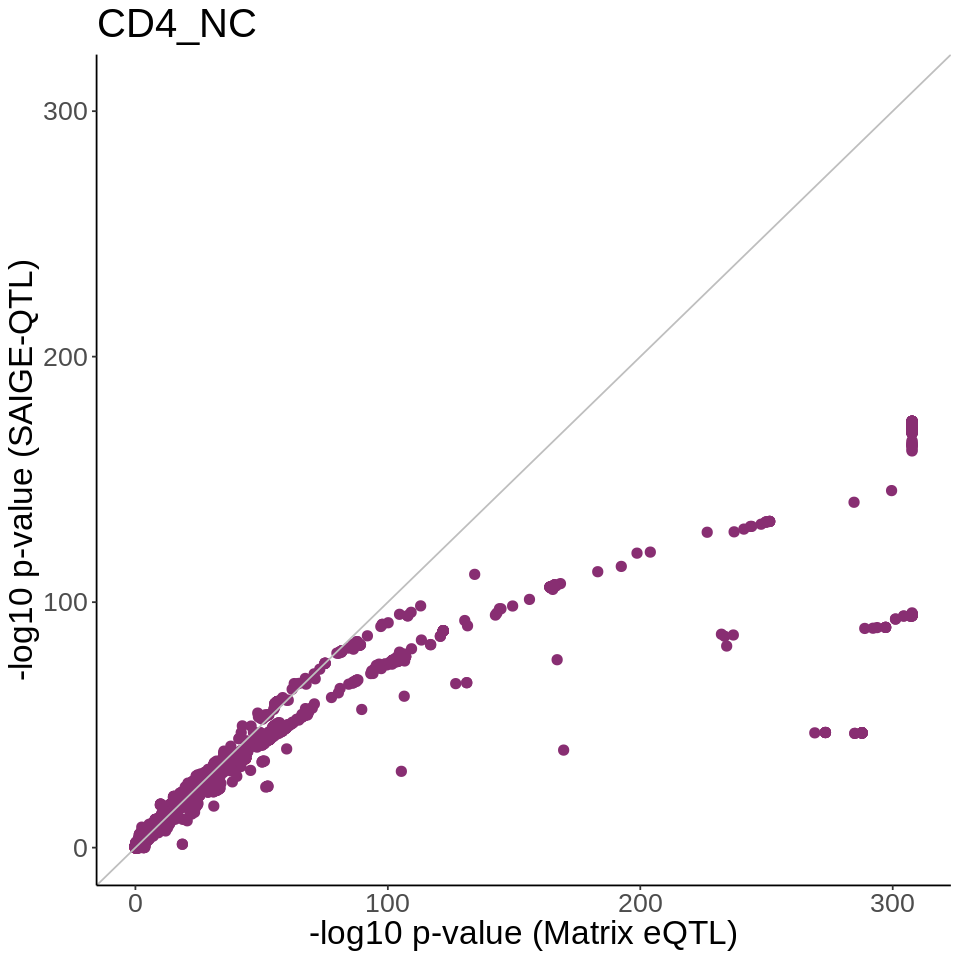

[1] "CD4_NC, cor pvs: 0.92, cor betas: 0.36"


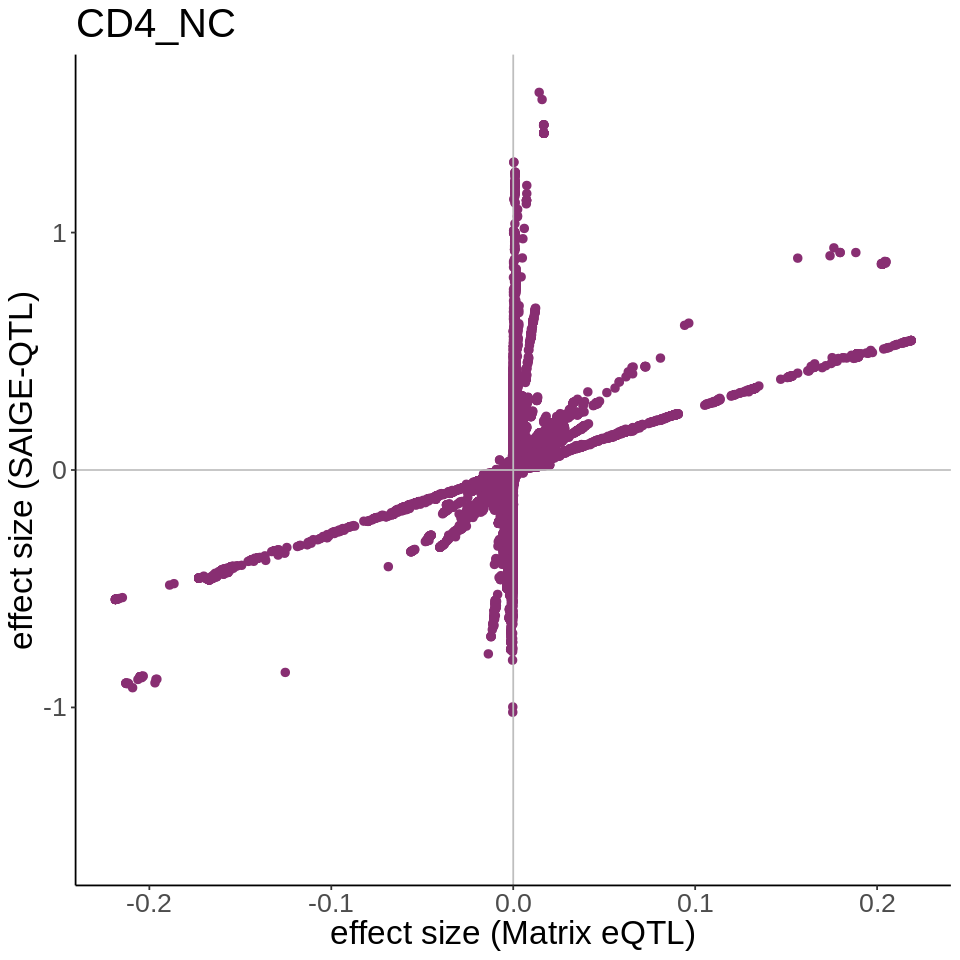

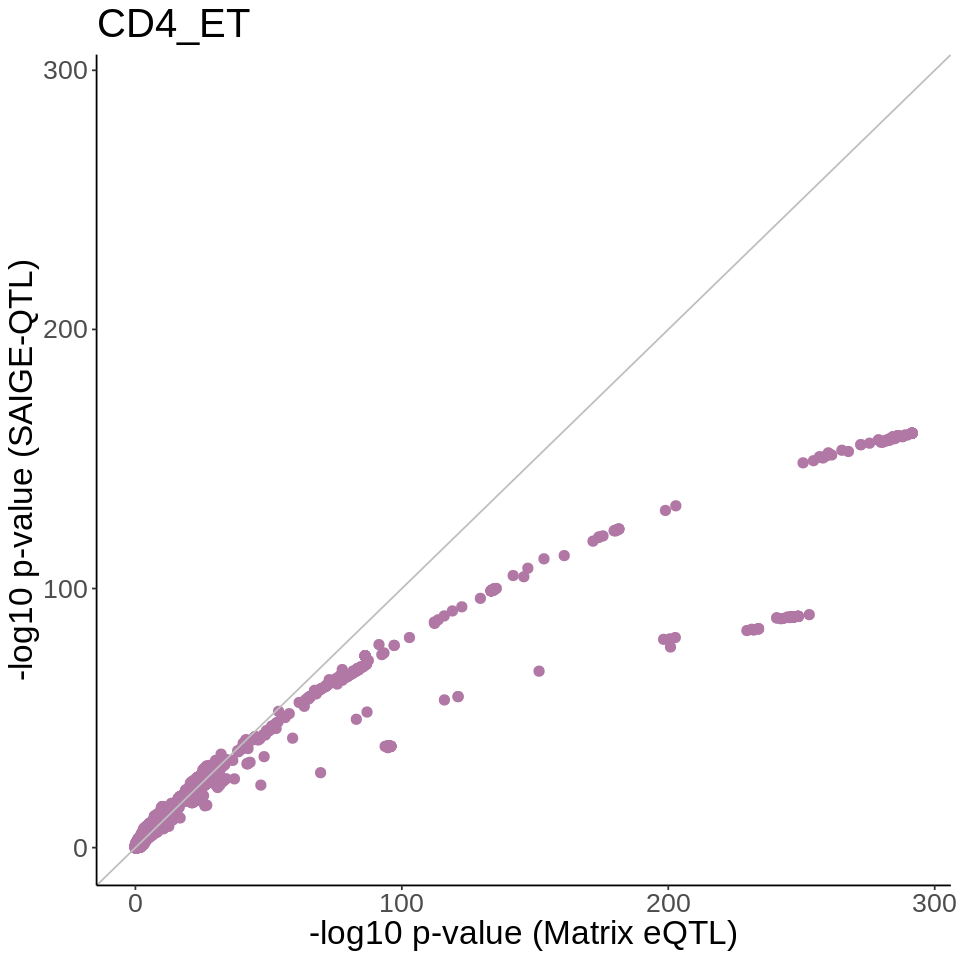

[1] "CD4_ET, cor pvs: 0.96, cor betas: 0.53"


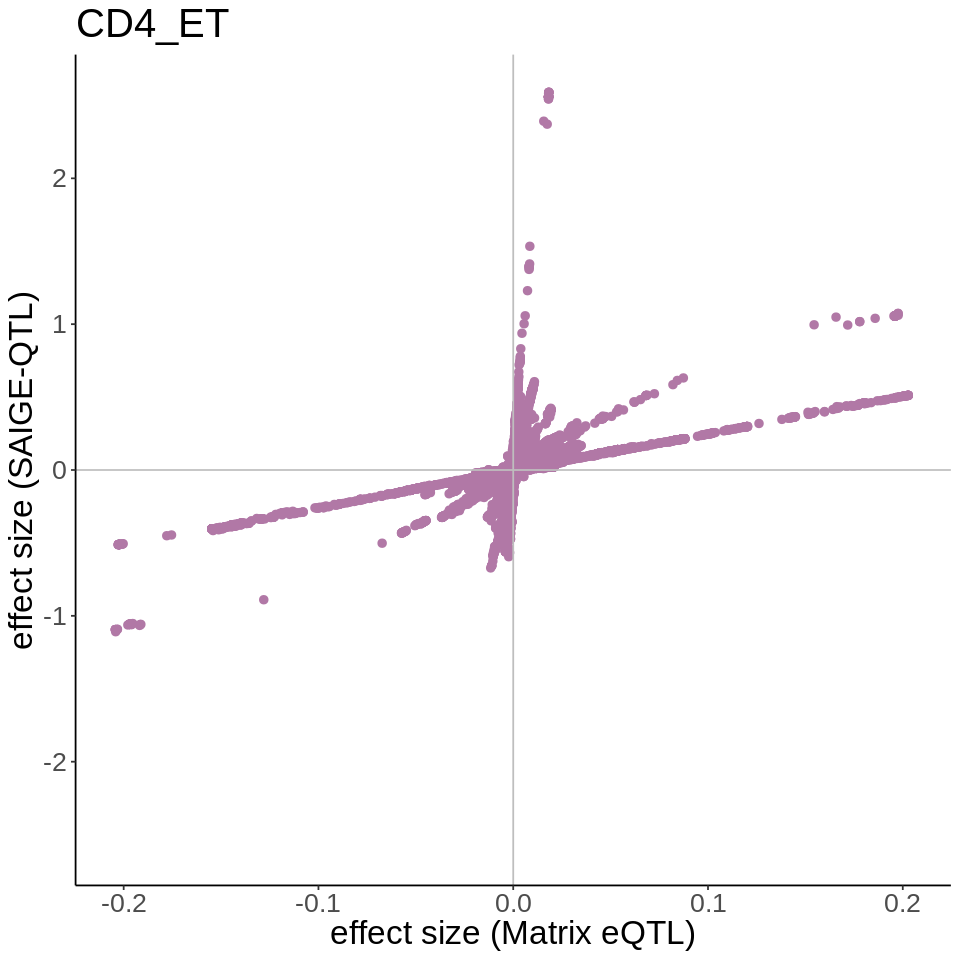

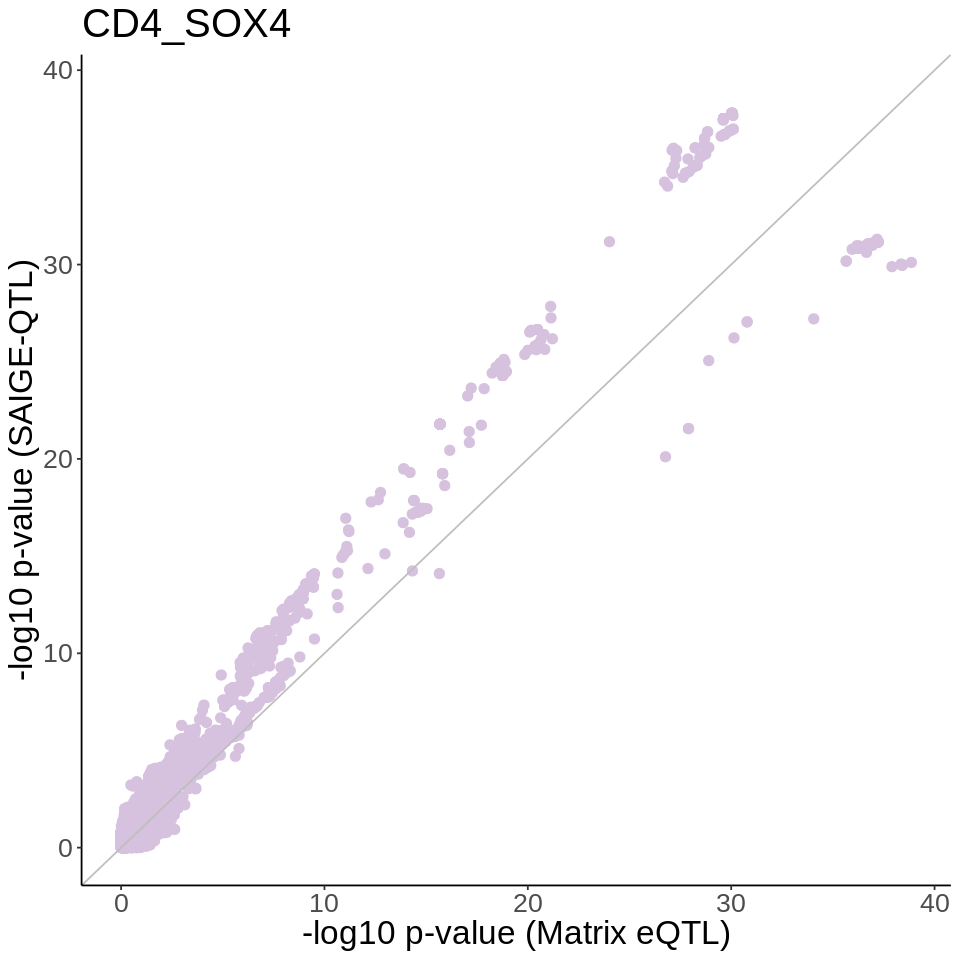

[1] "CD4_SOX4, cor pvs: 0.97, cor betas: 0.84"


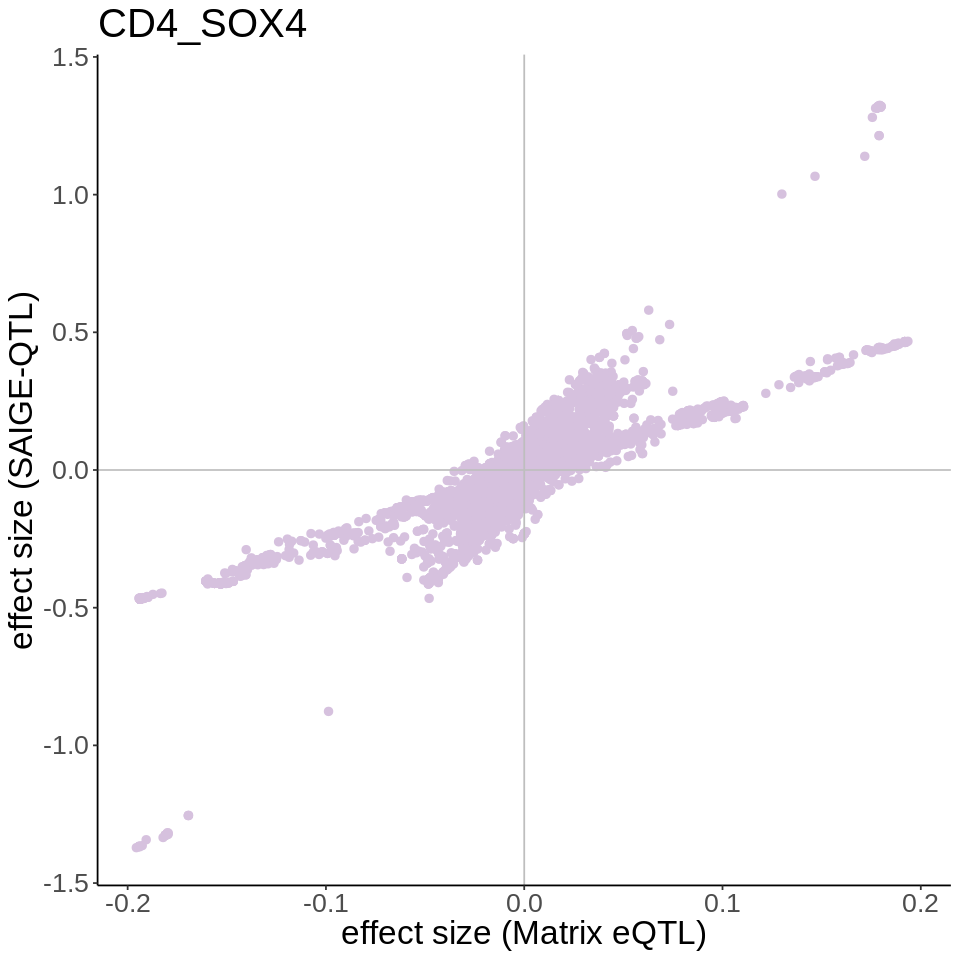

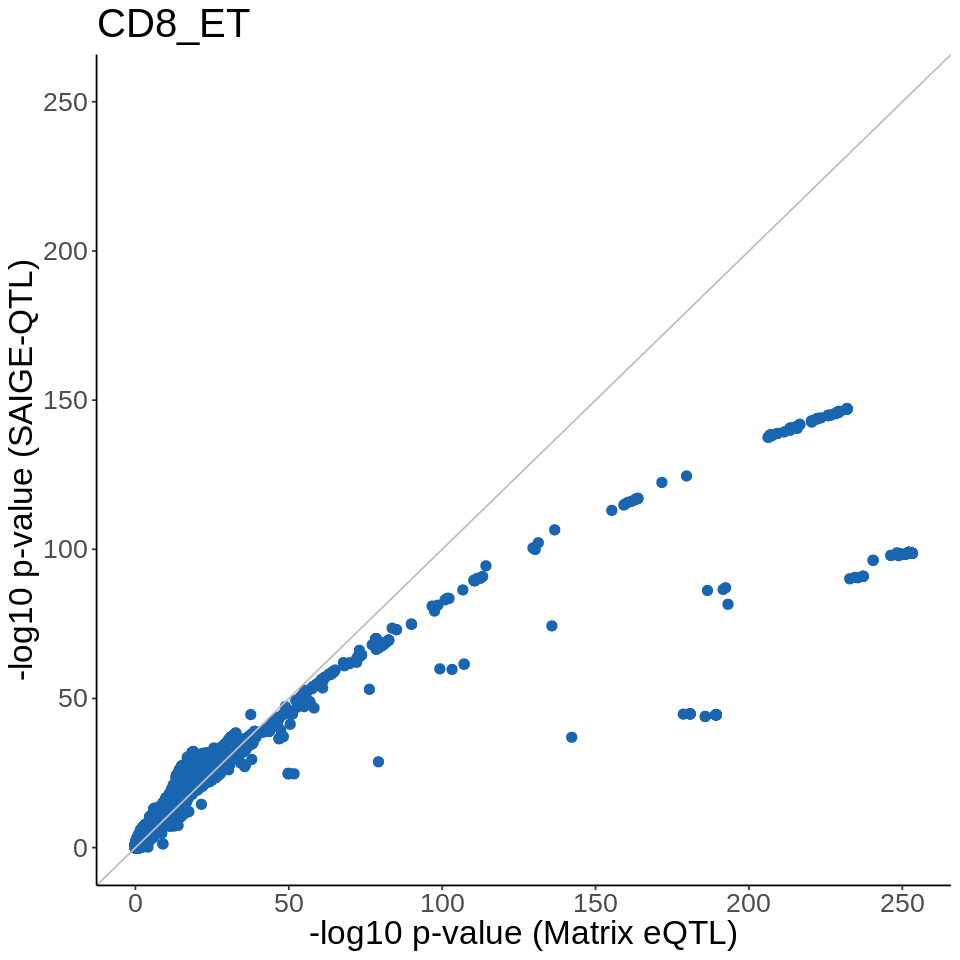

[1] "CD8_ET, cor pvs: 0.93, cor betas: 0.38"


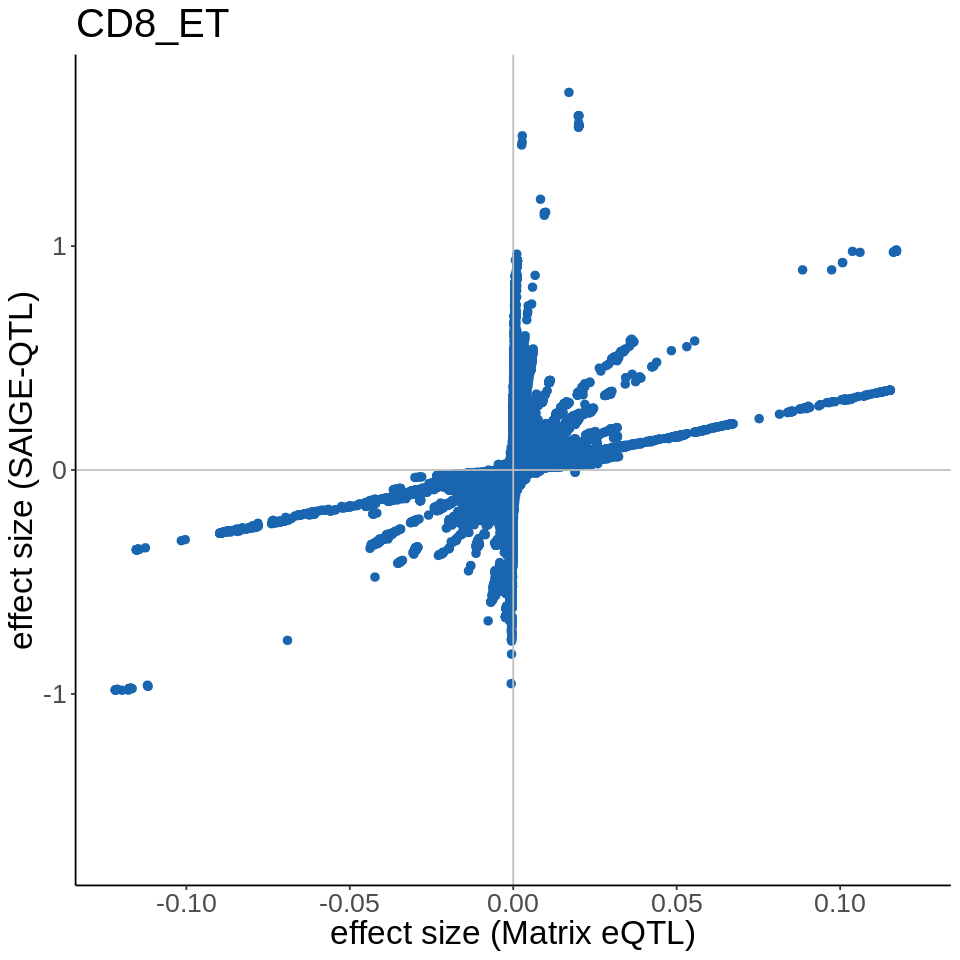

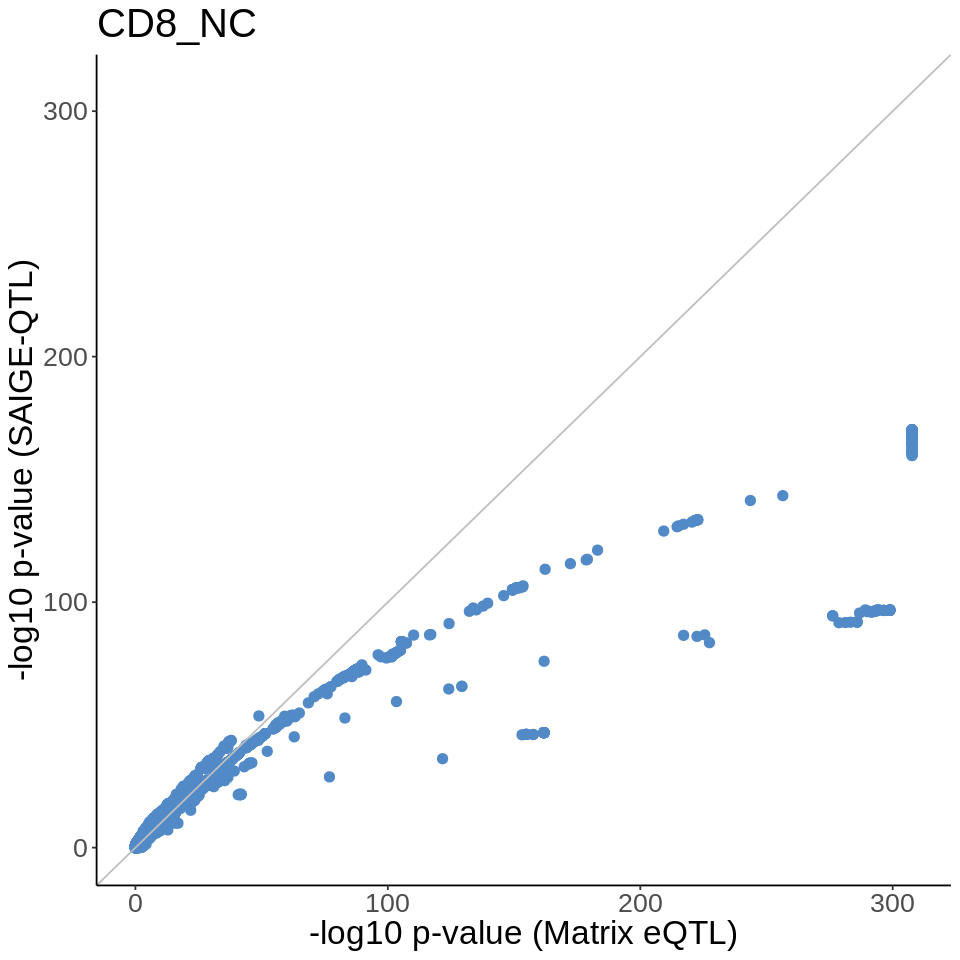

[1] "CD8_NC, cor pvs: 0.95, cor betas: 0.44"


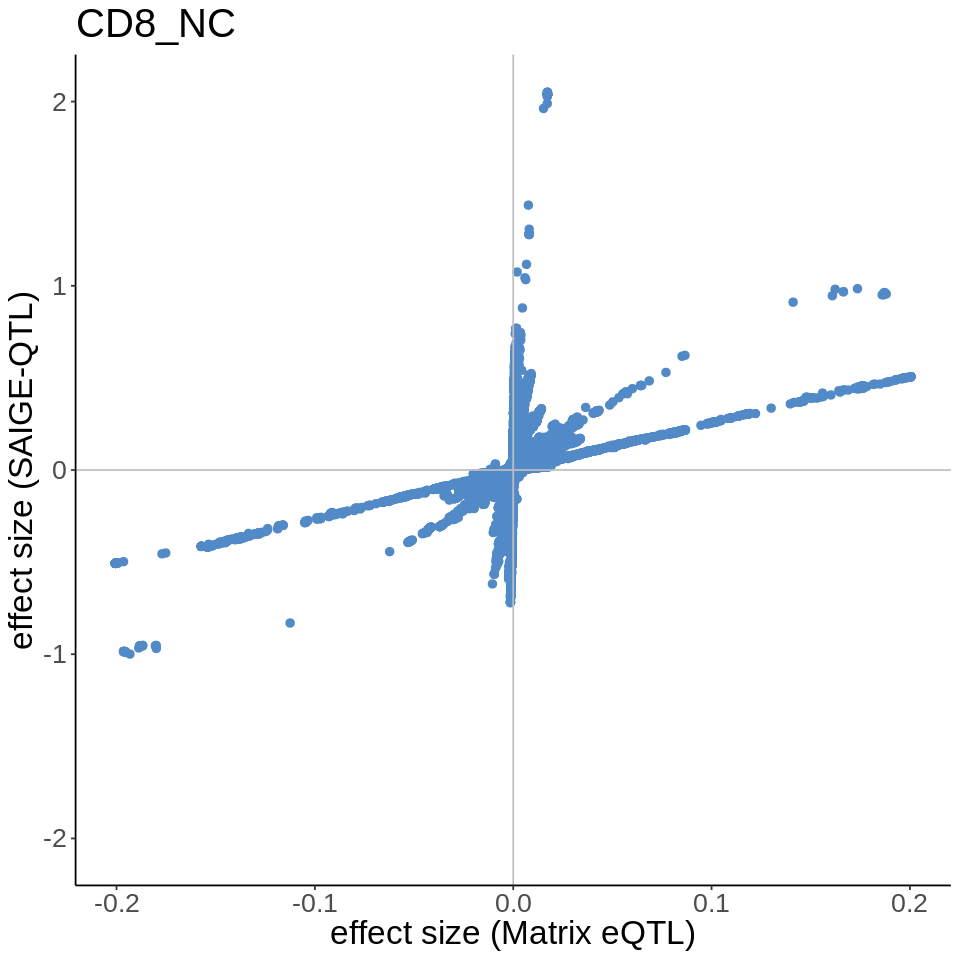

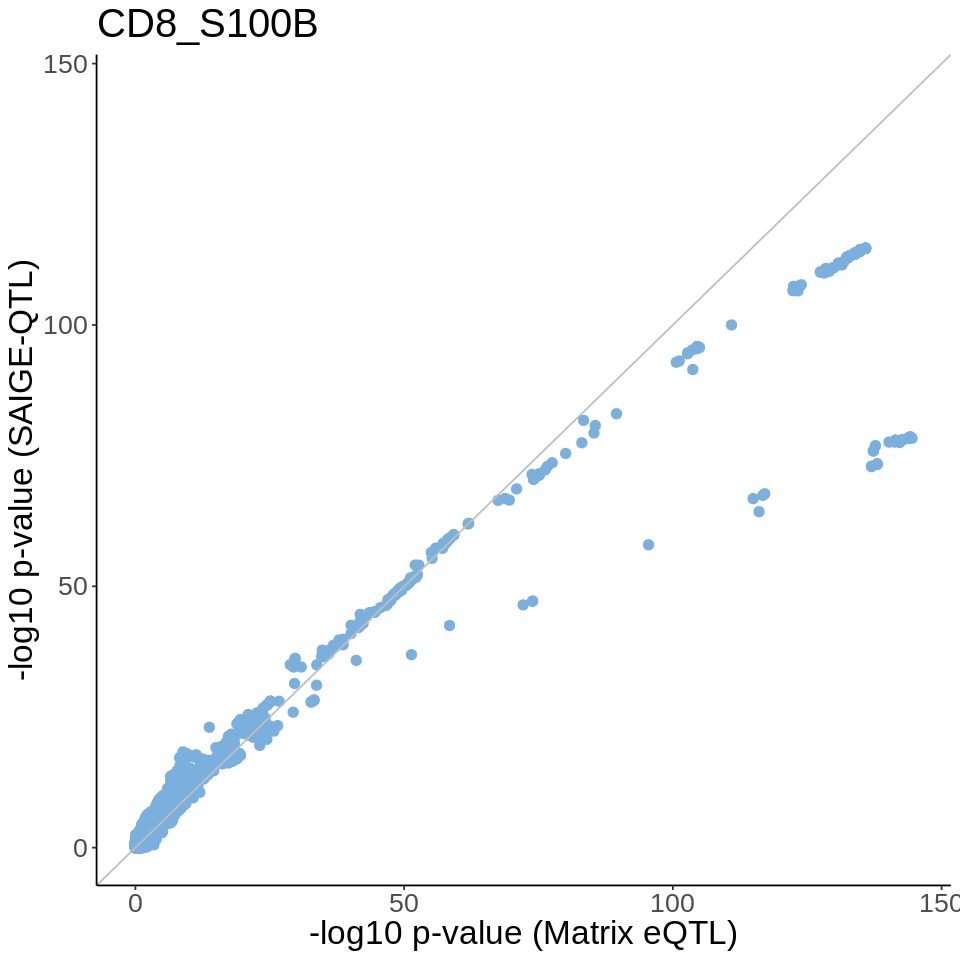

[1] "CD8_S100B, cor pvs: 0.97, cor betas: 0.53"


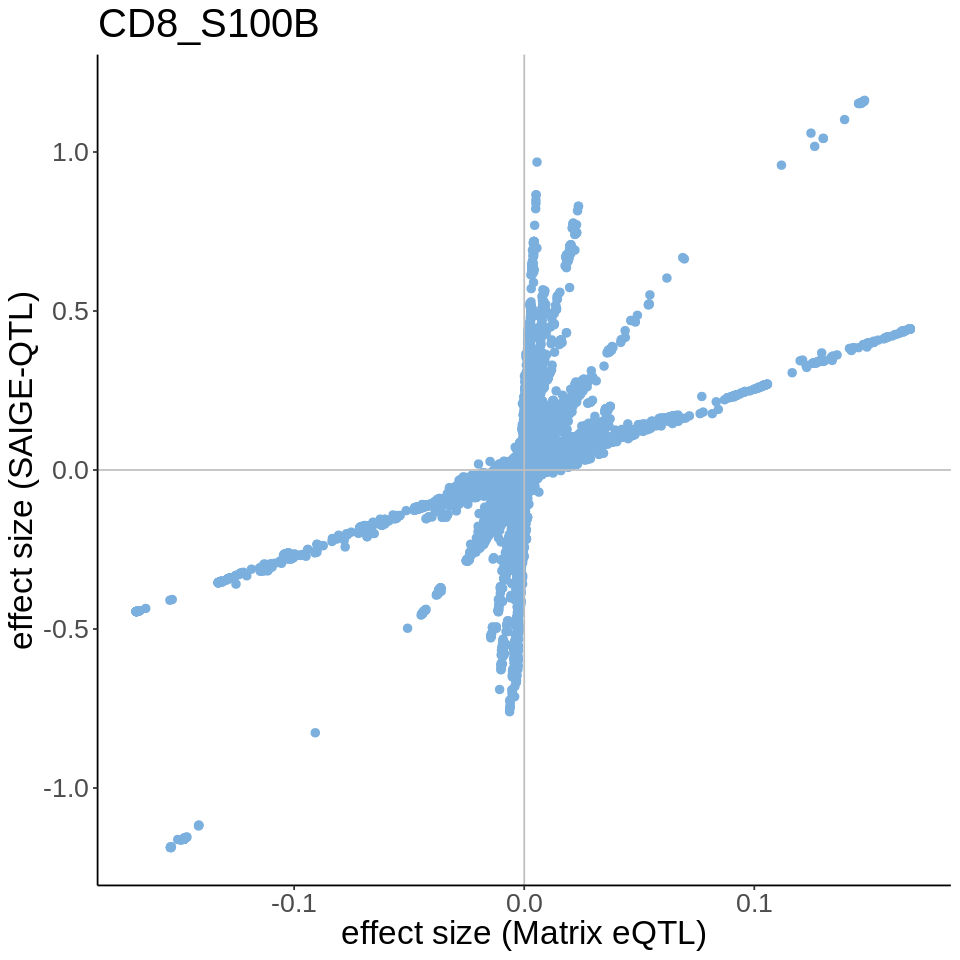

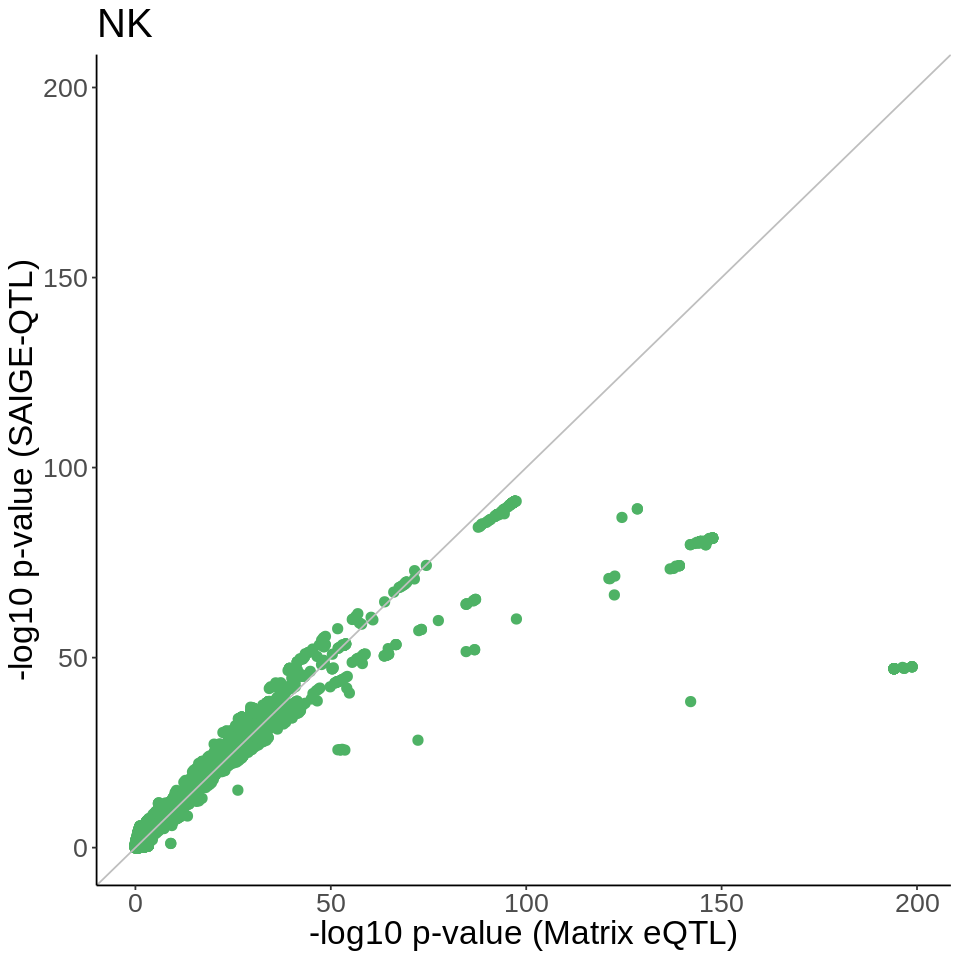

[1] "NK, cor pvs: 0.92, cor betas: 0.36"


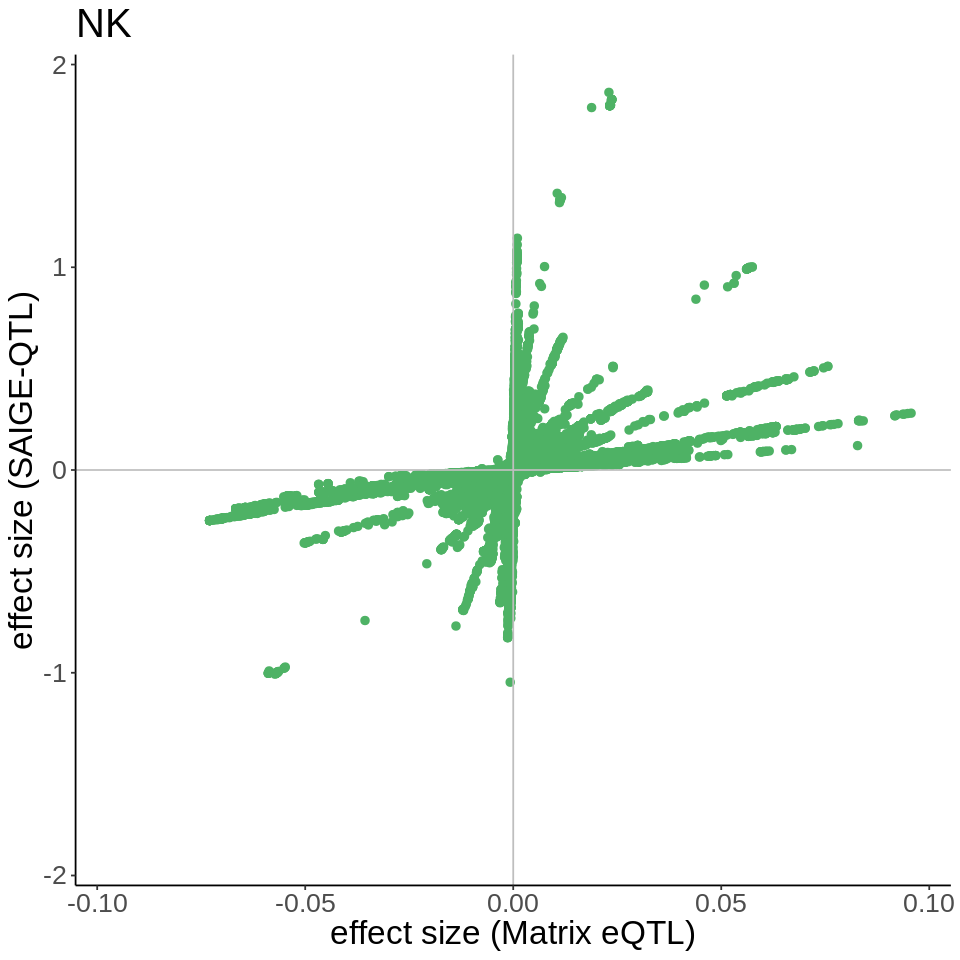

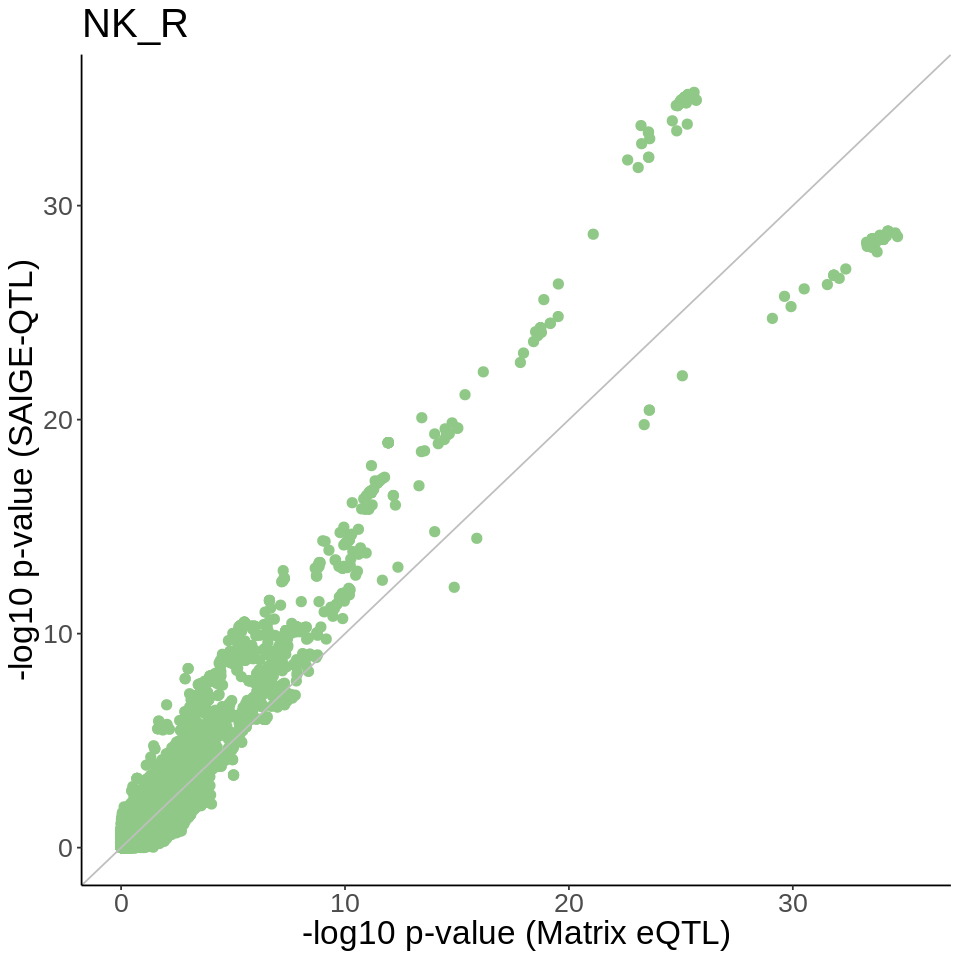

[1] "NK_R, cor pvs: 0.96, cor betas: 0.52"


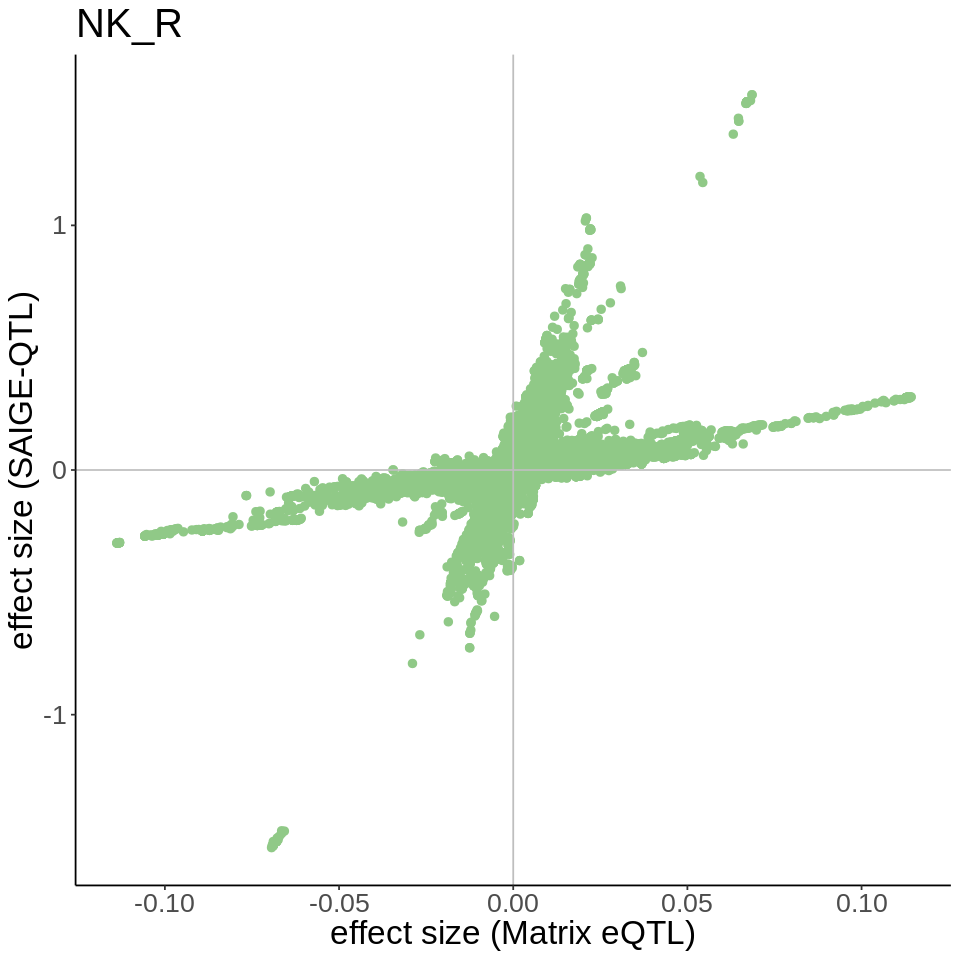

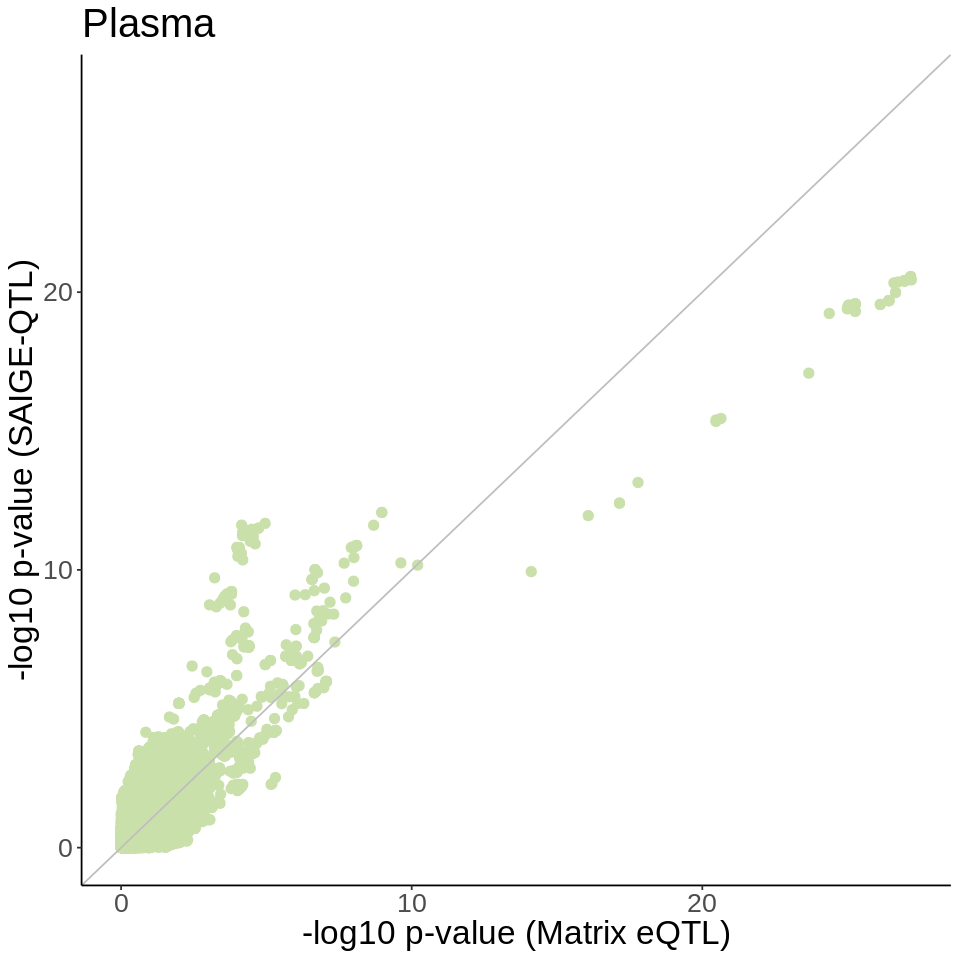

[1] "Plasma, cor pvs: 0.86, cor betas: 0.63"


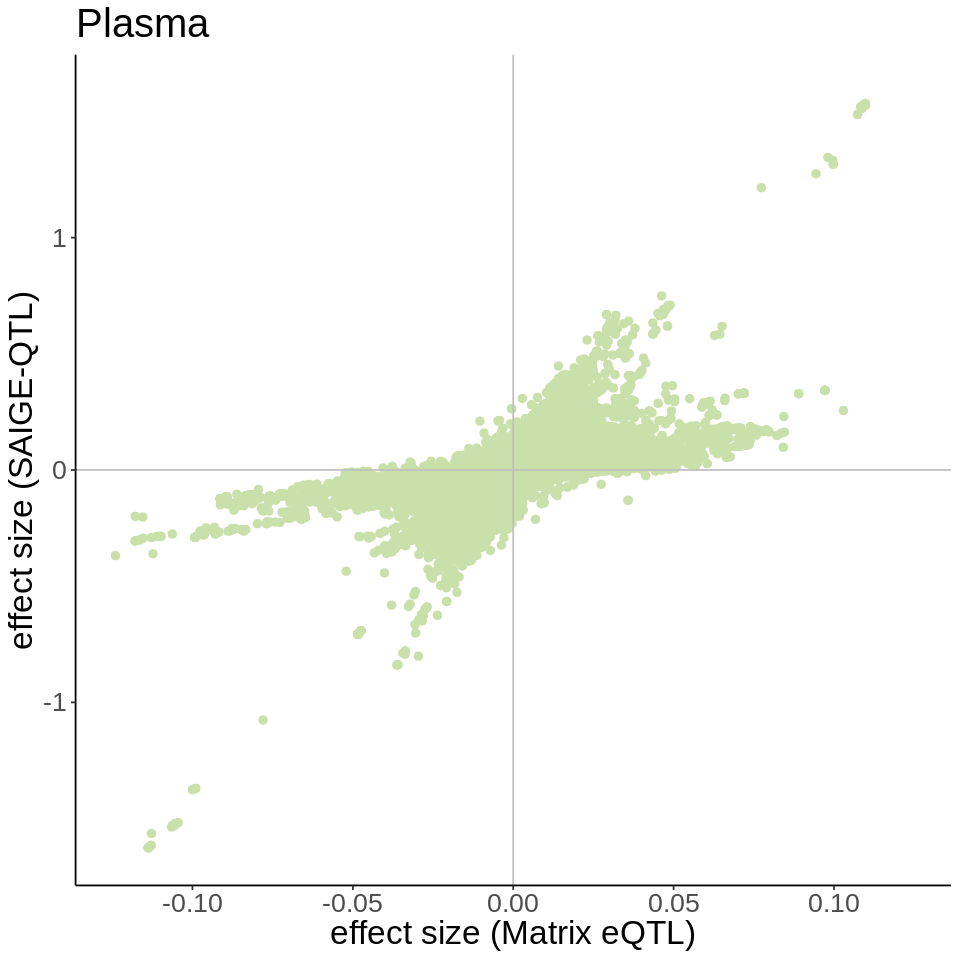

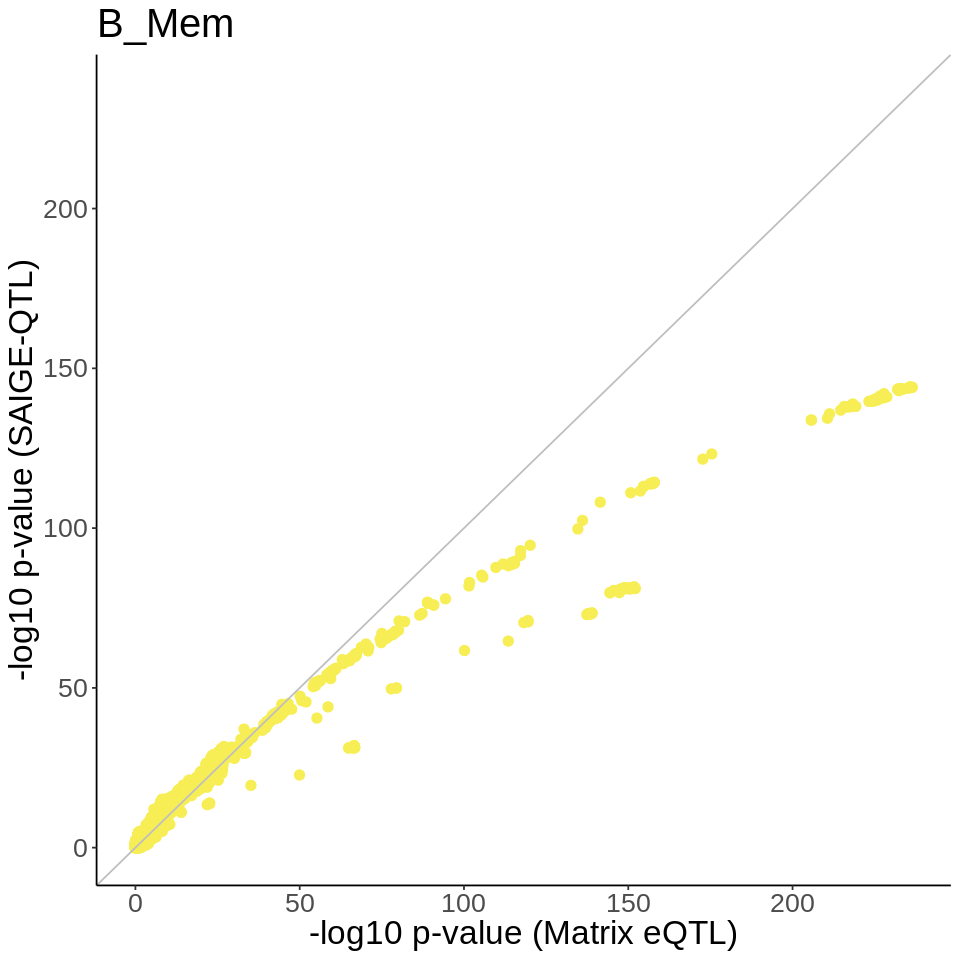

[1] "B_Mem, cor pvs: 0.98, cor betas: 0.5"


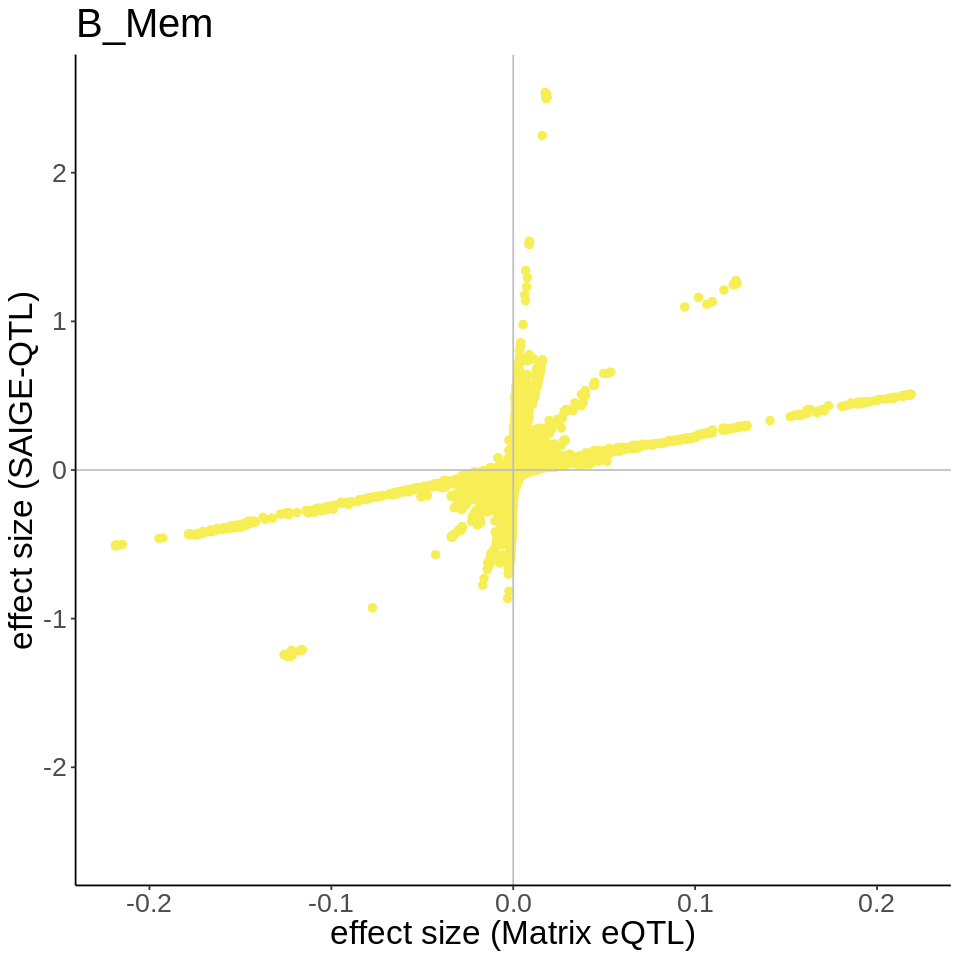

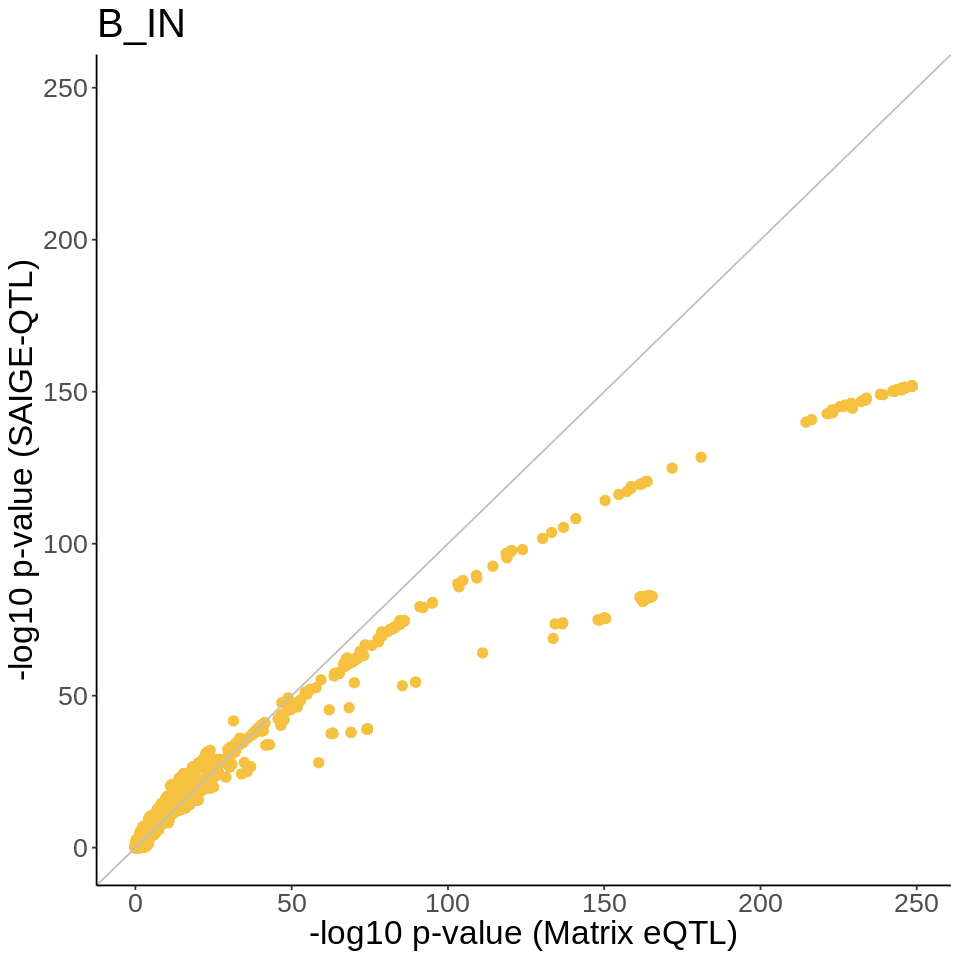

[1] "B_IN, cor pvs: 0.98, cor betas: 0.44"


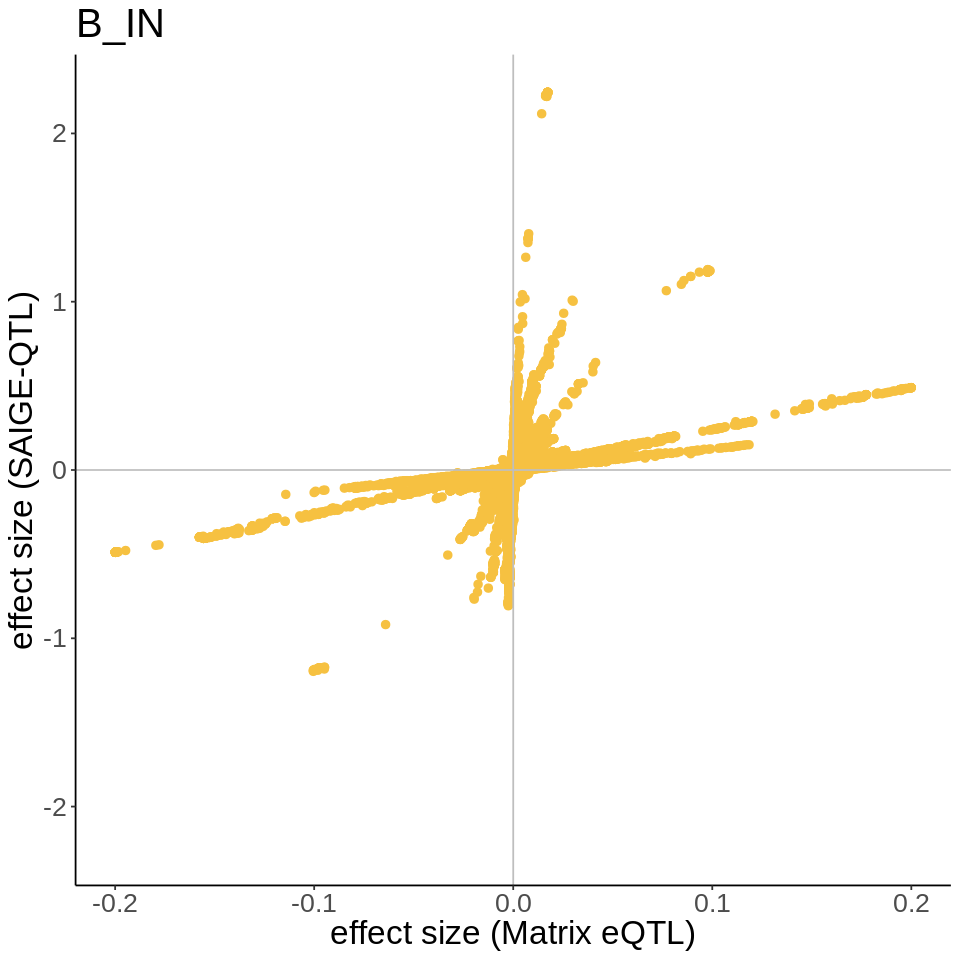

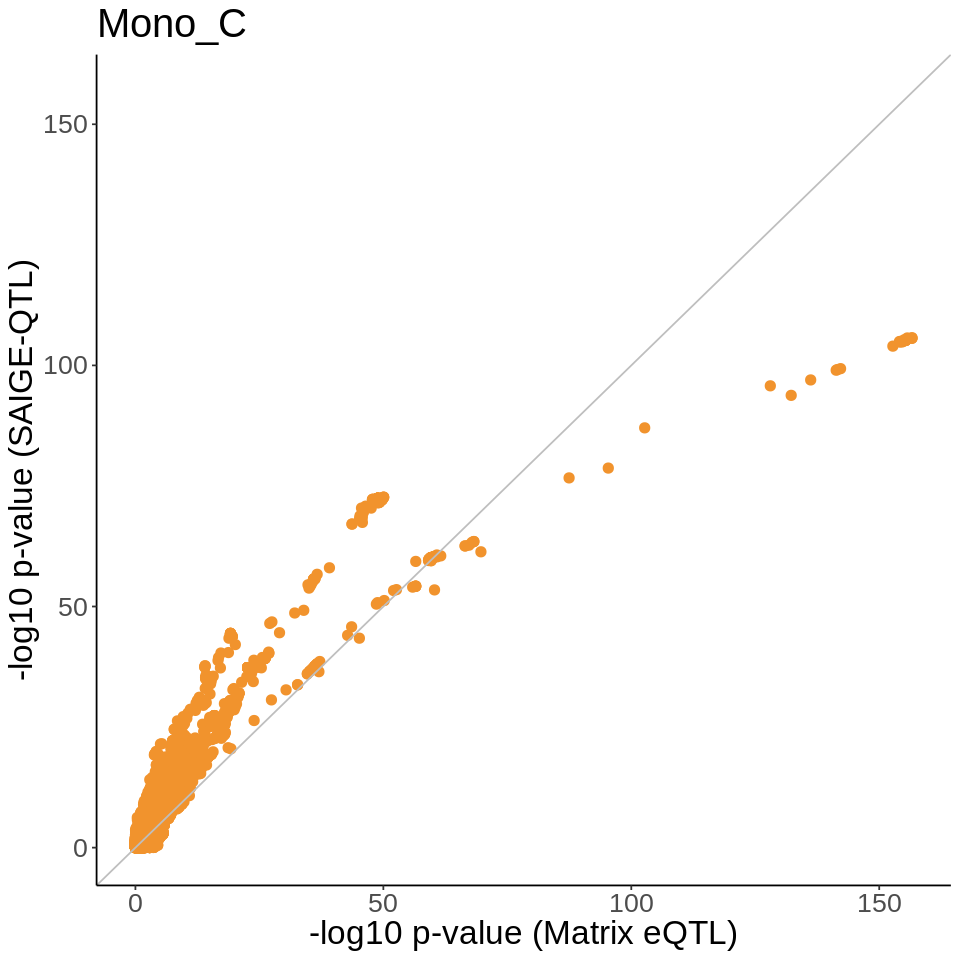

[1] "Mono_C, cor pvs: 0.91, cor betas: 0.53"


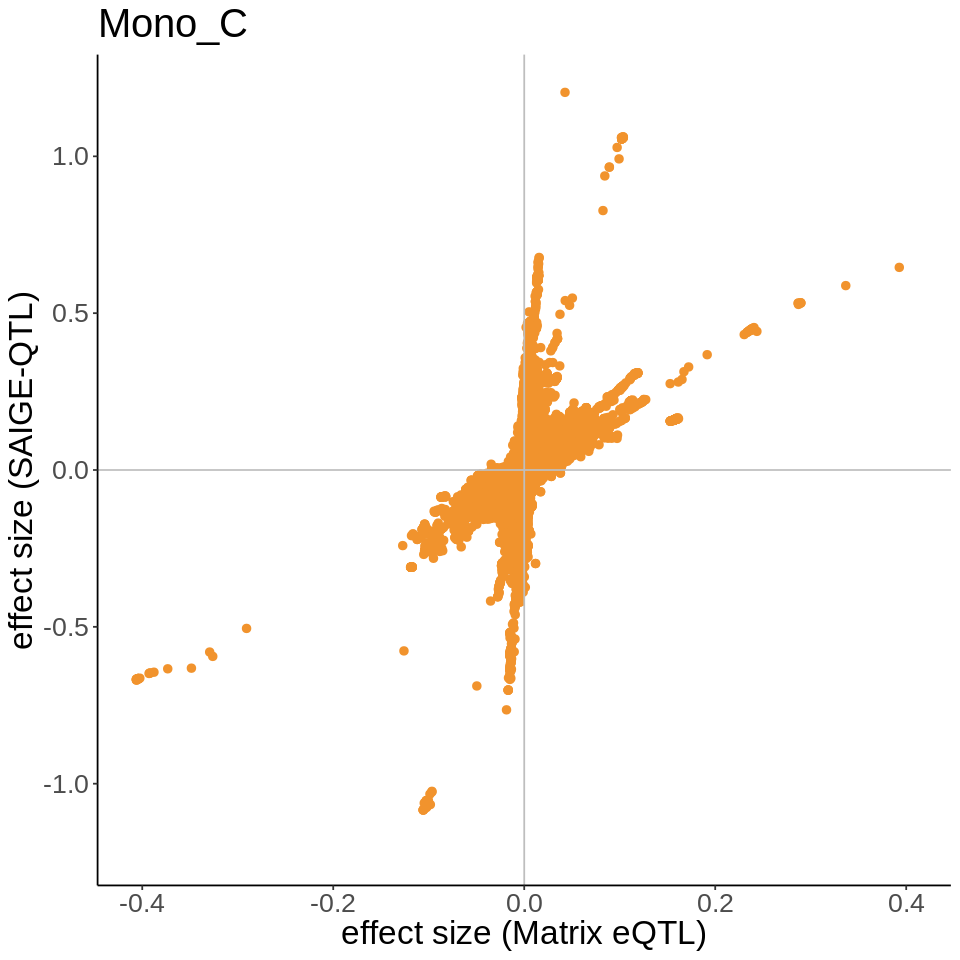

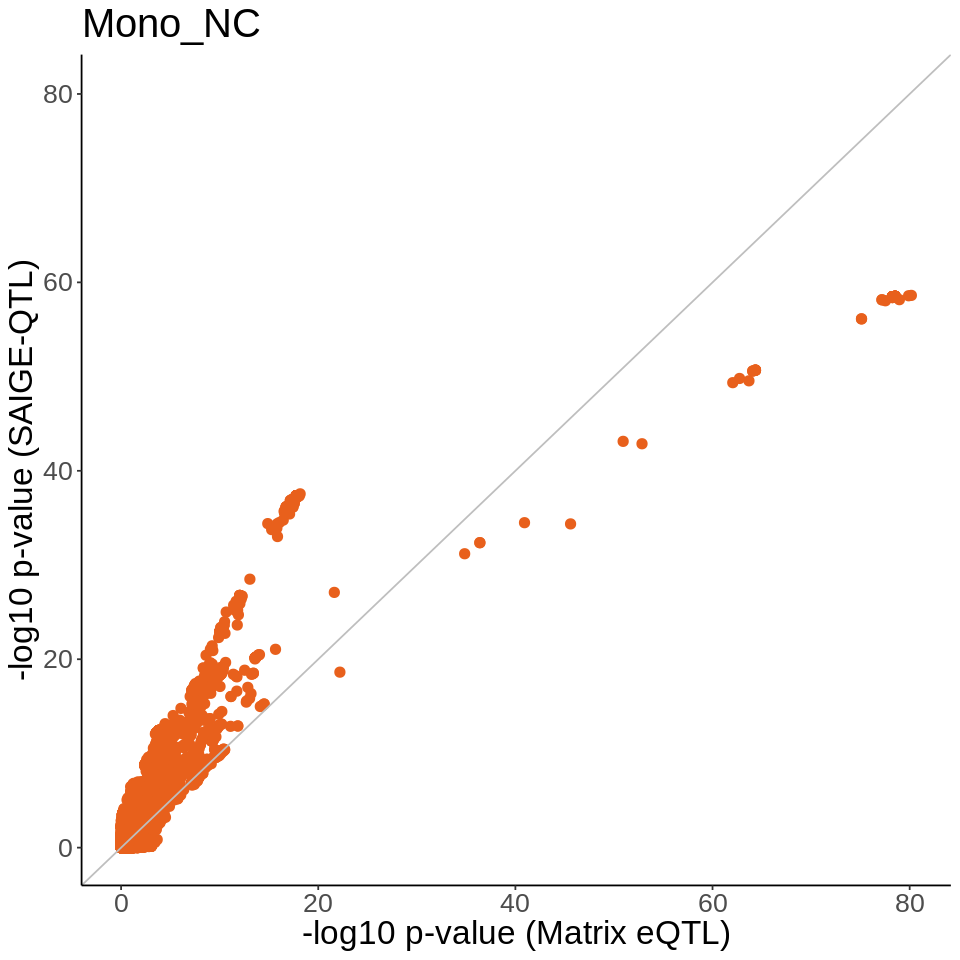

[1] "Mono_NC, cor pvs: 0.87, cor betas: 0.64"


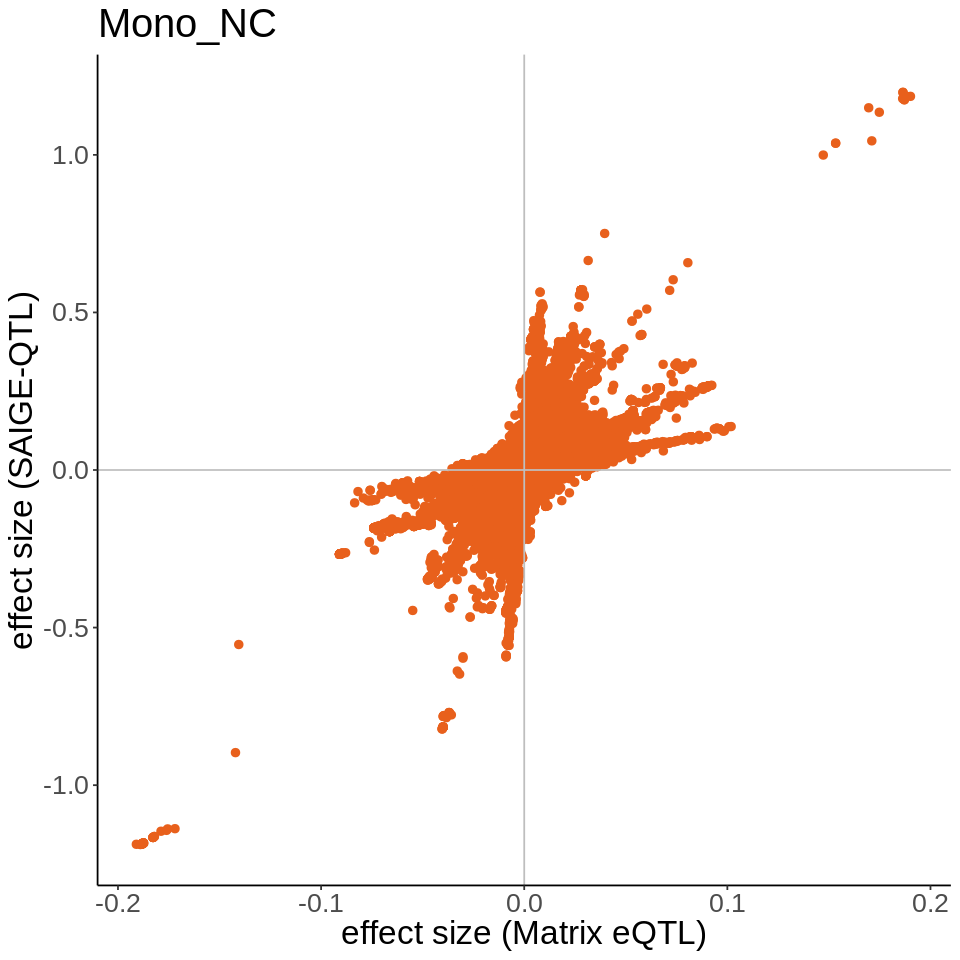

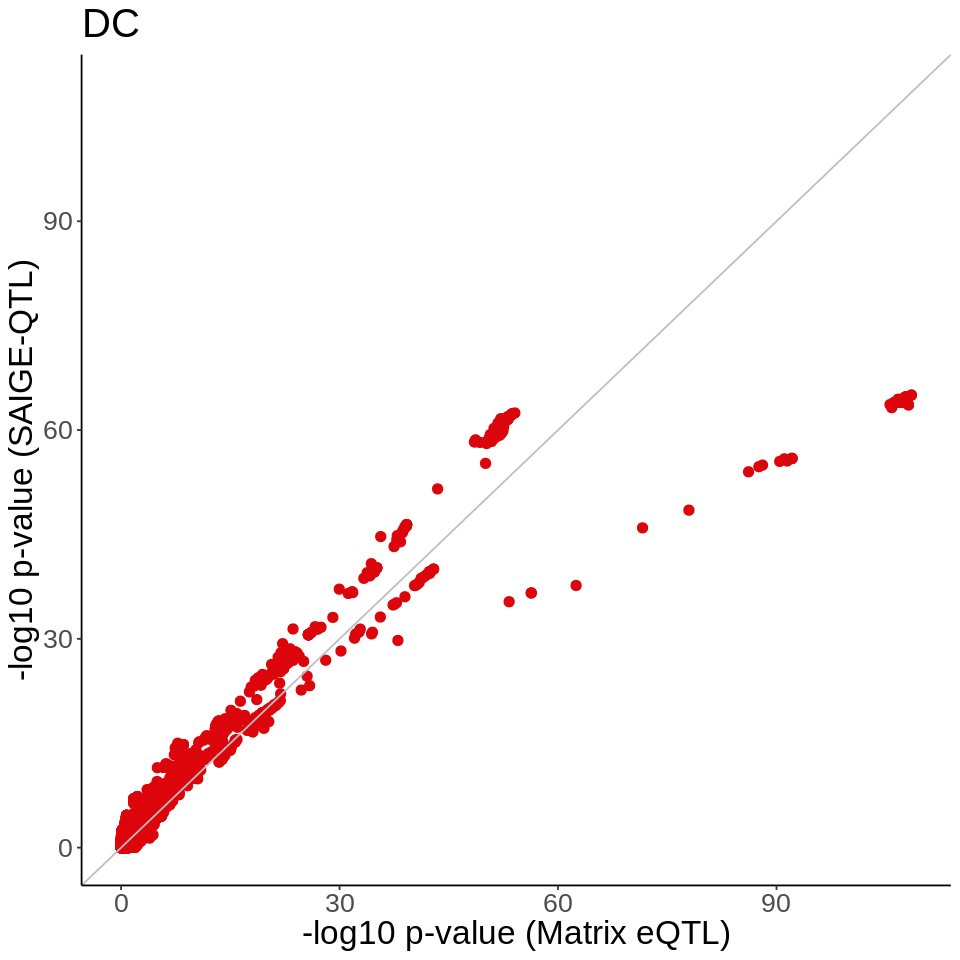

[1] "DC, cor pvs: 0.95, cor betas: 0.67"


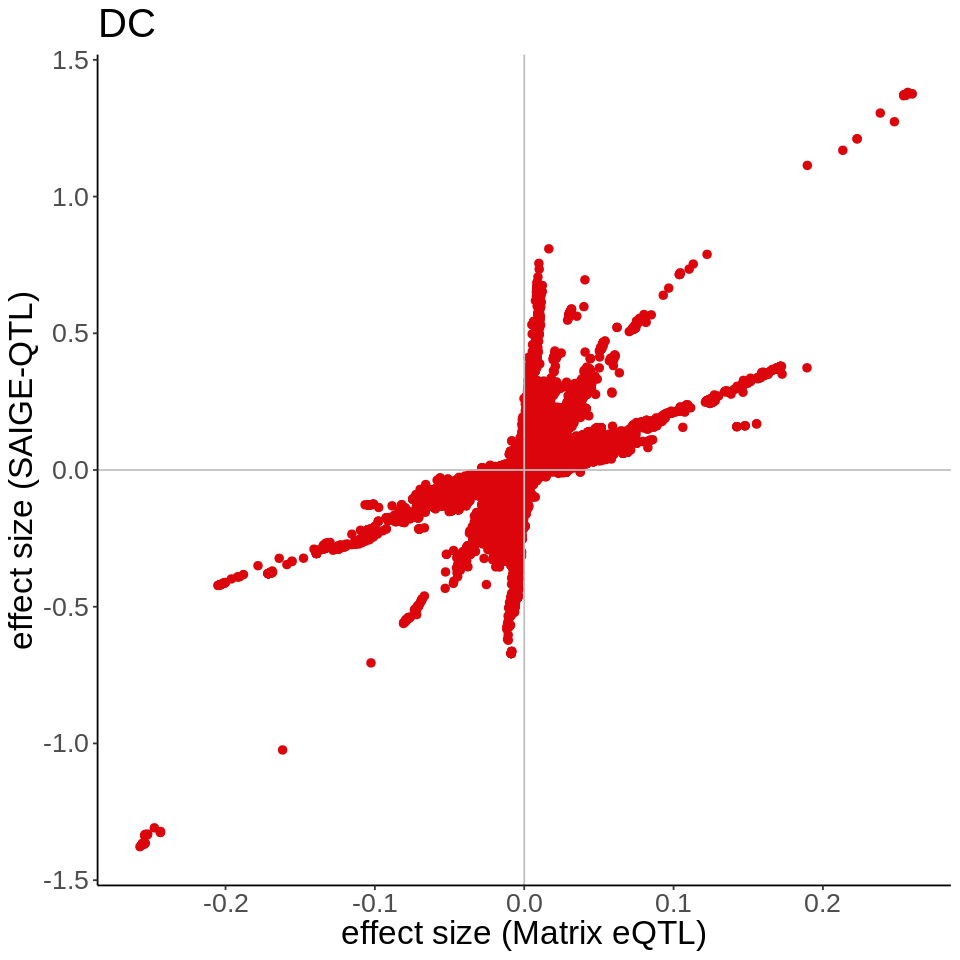

In [136]:
options(repr.plot.width = 8, repr.plot.height = 8)
cors_pvs = c()
cors_betas = c()
for (ct in celltypes){
    # load combined results
    df_both = fread(paste0(output_dir,"combined_",ct,".csv"))
    # establish plot colour based on cell type
    col = df_colours[df_colours$celltype == ct,"colours"]
    # plot p-values
    m = -log10(min(min(df_both$pval_matrix),min(df_both$pval_saige)))
    p = ggplot(df_both, aes(x=-log10(pval_matrix), y=-log10(pval_saige))) + geom_point(col=col, size=2.5) 
    p = p + geom_abline(slope = 1, intercept = 0, col = "gray") + theme_classic()
    p = p + theme(text = element_text(size=20)) + xlim(c(0,m)) + ylim(c(0,m))
    p = p + xlab("-log10 p-value (Matrix eQTL)") + ylab("-log10 p-value (SAIGE-QTL)")
    p = p + ggtitle(ct)
    print(p)
    # save
    pdf(paste0(fig_dir,ct,"_pvals_scatter.pdf"), width=8, height=8)
    print(p)
    dev.off()
    # plot betas
    M_saige = max(abs(df_both$beta_saige))
    M_matrix = max(abs(df_both$beta_matrix))
    p = ggplot(df_both, aes(x=beta_matrix, y=beta_saige)) + geom_point(col=col, size=2) 
    p = p + geom_vline(xintercept = 0, col = "gray") + geom_hline(yintercept = 0, col = "gray") 
    p = p + theme_classic() + theme(text = element_text(size=20))
    p = p + xlim(c(-M_matrix,M_matrix)) + ylim(c(-M_saige,M_saige))
    p = p + xlab("effect size (Matrix eQTL)") + ylab("effect size (SAIGE-QTL)")
    p = p + ggtitle(ct)
    print(p)
    # save
    pdf(paste0(fig_dir,ct,"_betas_scatter.pdf"), width=8, height=8)
    print(p)
    dev.off()
    # print correlations
    cor_pvs = cor(-log10(df_both$pval_matrix), -log10(df_both$pval_saige))
    cor_betas = cor(df_both$beta_matrix, df_both$beta_saige)
    print(paste0(ct,", cor pvs: ",round(cor_pvs,digits=2),", cor betas: ",round(cor_betas,digits=2)))
    cors_pvs = c(cors_pvs, cor_pvs)
    cors_betas = c(cors_betas, cor_betas)
}

In [138]:
mean(cors_pvs)
mean(cors_betas)

[1] 0.9372671

[1] 0.5271261

[1] "CD4_NC, cor abs betas: 0.31"


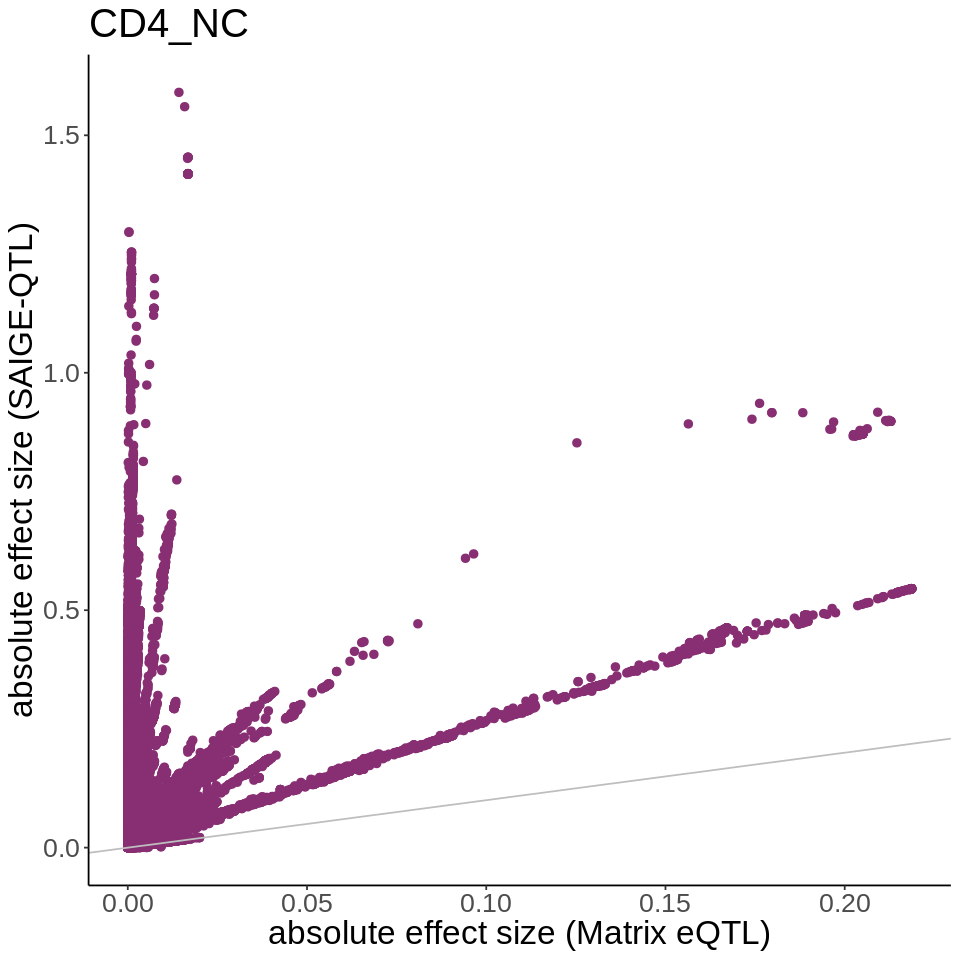

[1] "CD4_ET, cor abs betas: 0.45"


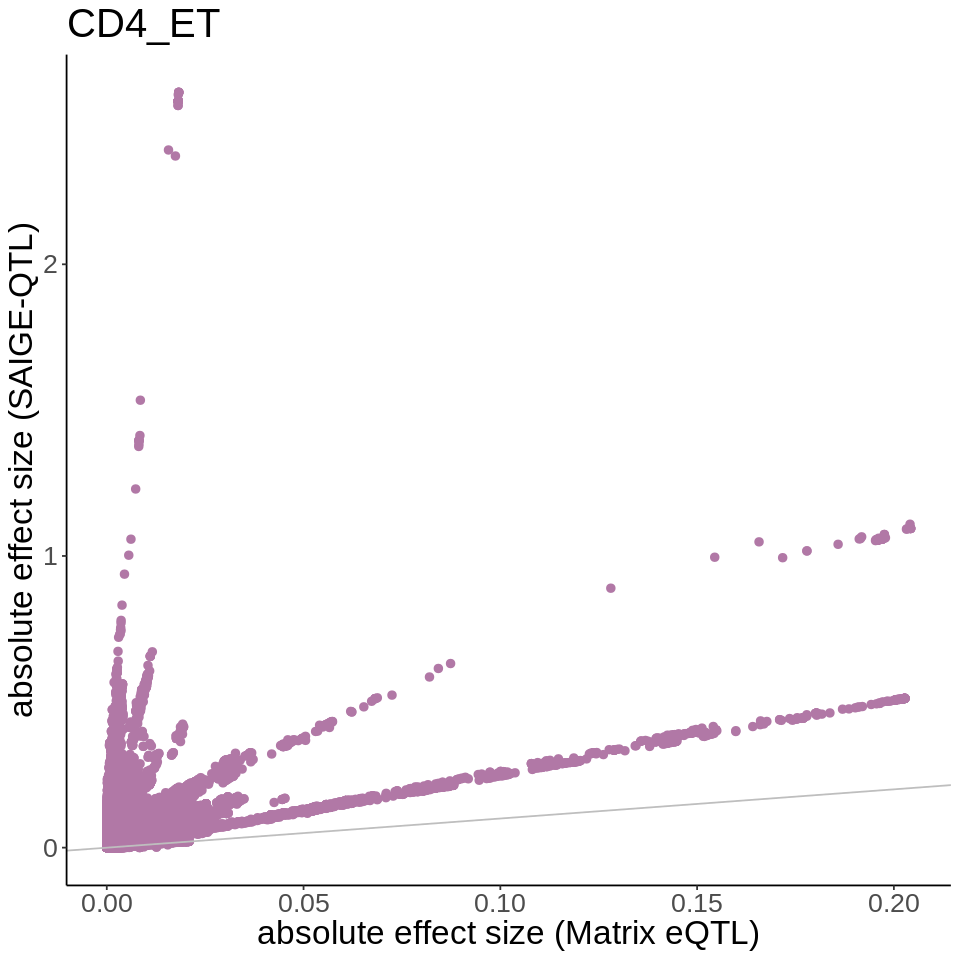

[1] "CD4_SOX4, cor abs betas: 0.76"


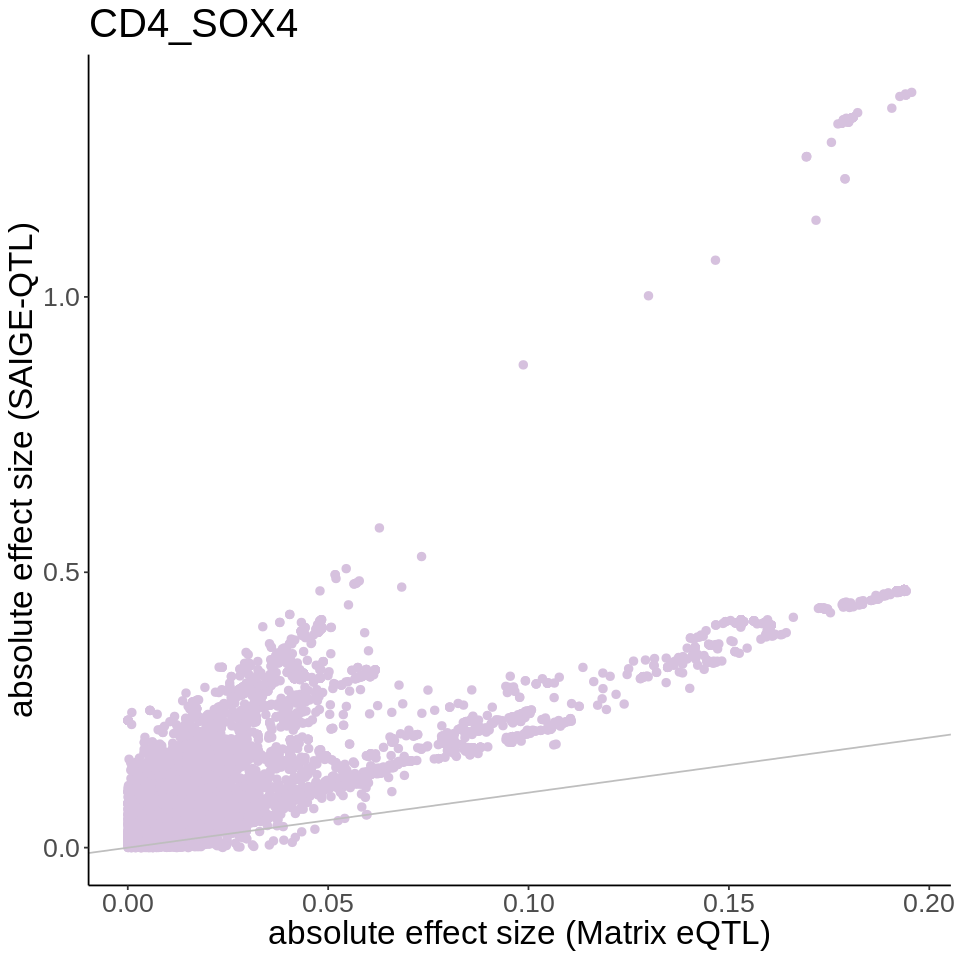

[1] "CD8_ET, cor abs betas: 0.25"


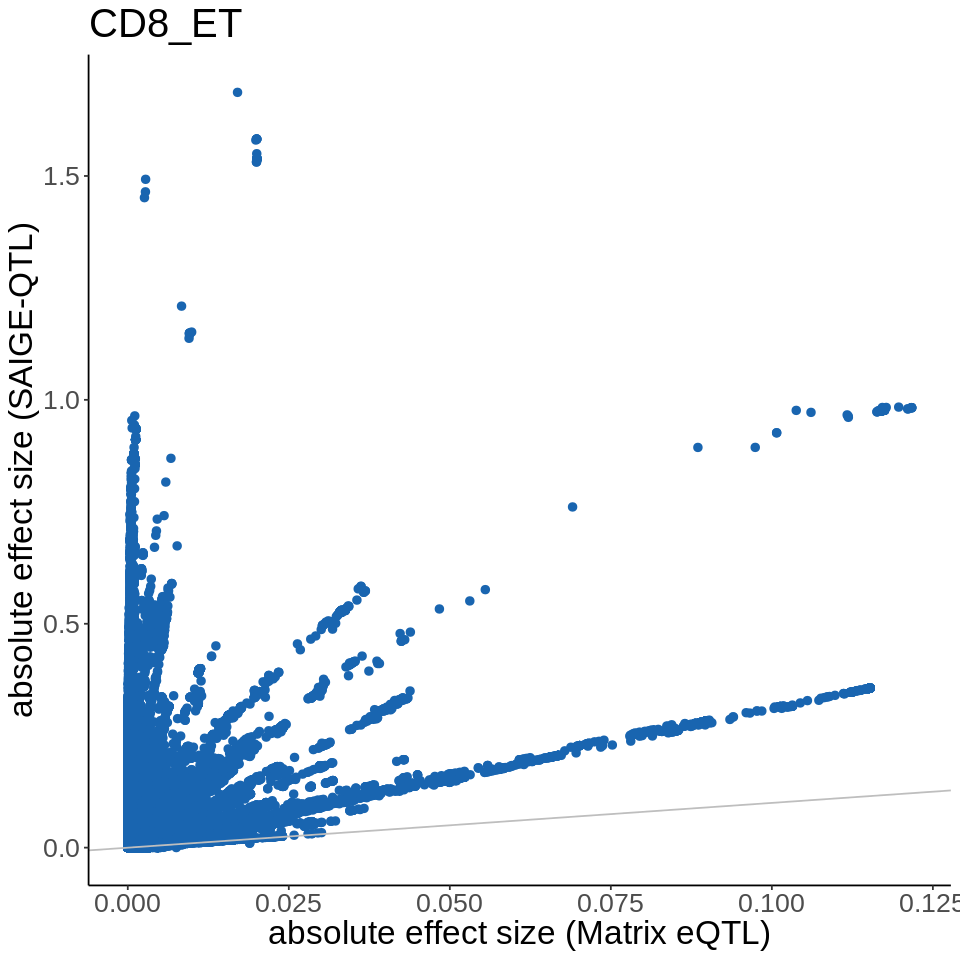

[1] "CD8_NC, cor abs betas: 0.37"


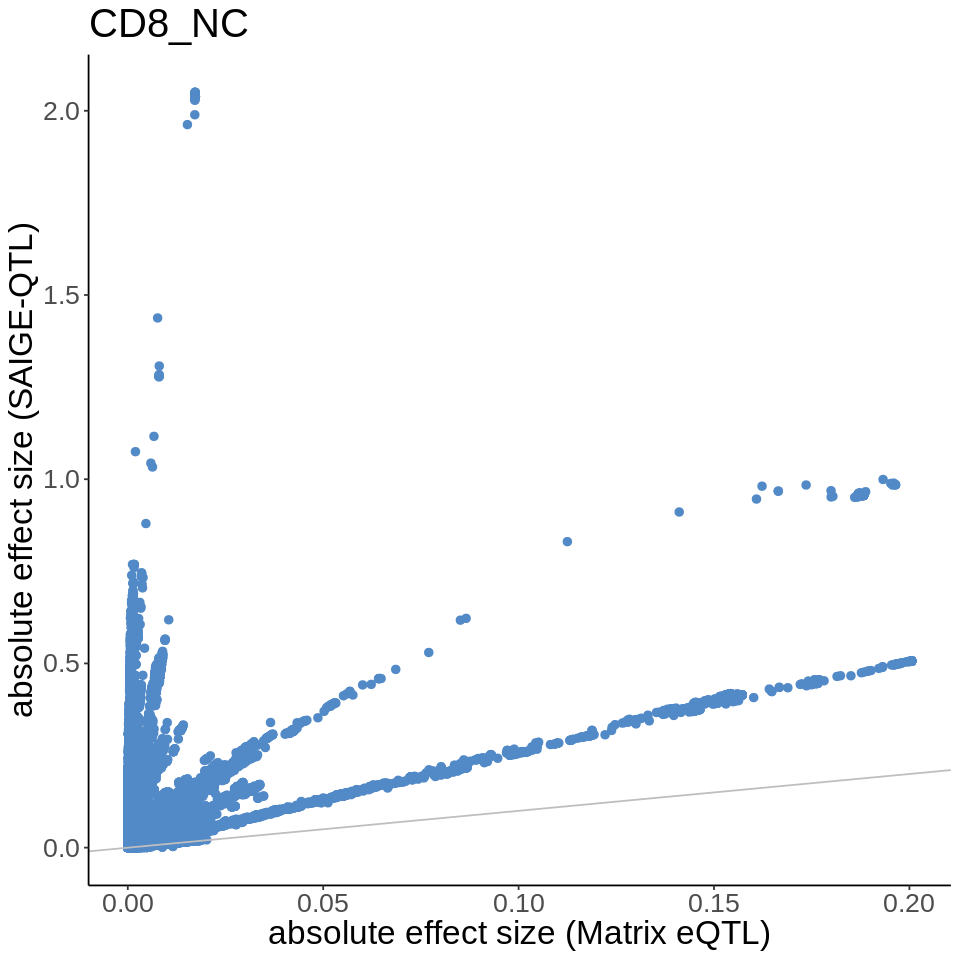

[1] "CD8_S100B, cor abs betas: 0.41"


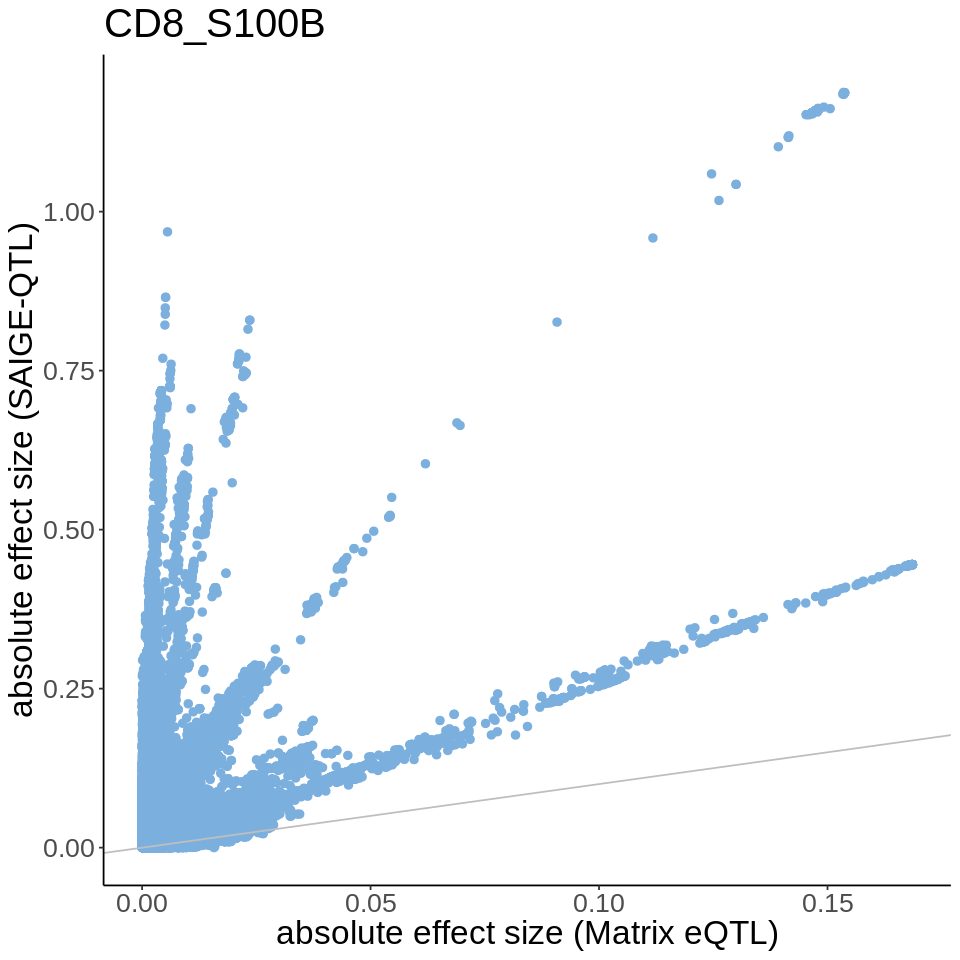

[1] "NK, cor abs betas: 0.19"


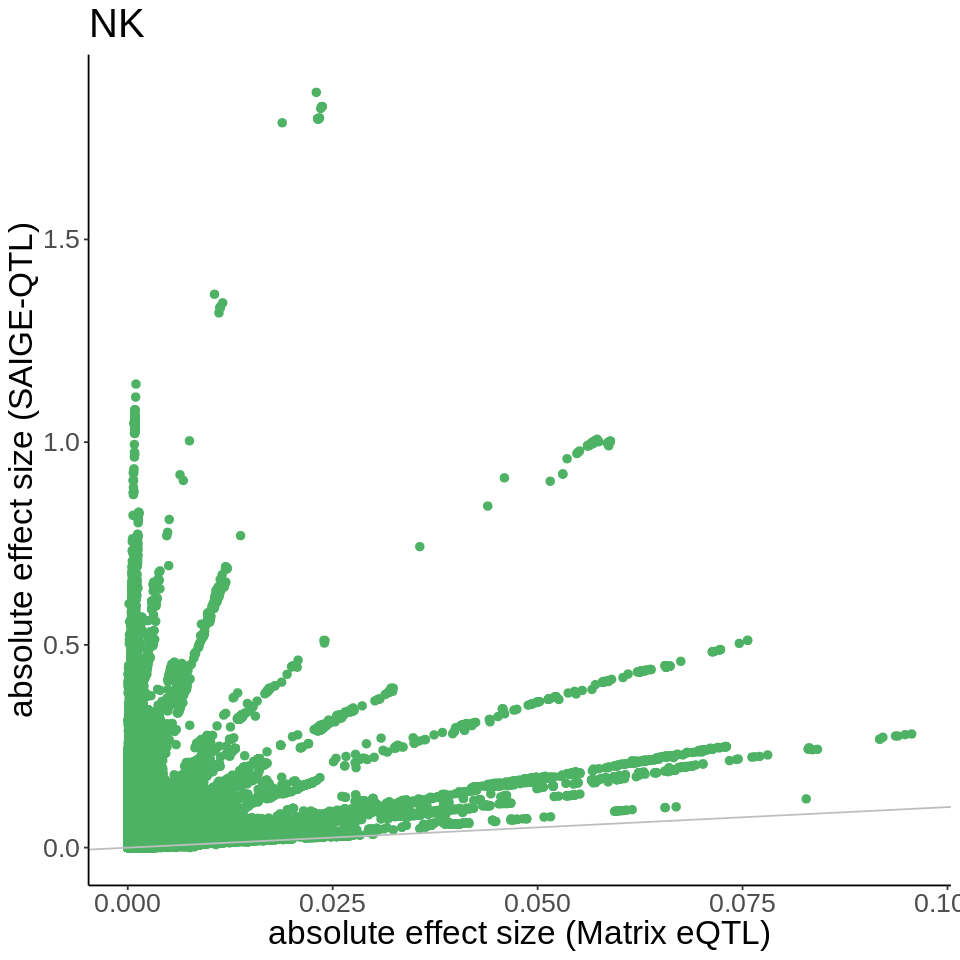

[1] "NK_R, cor abs betas: 0.3"


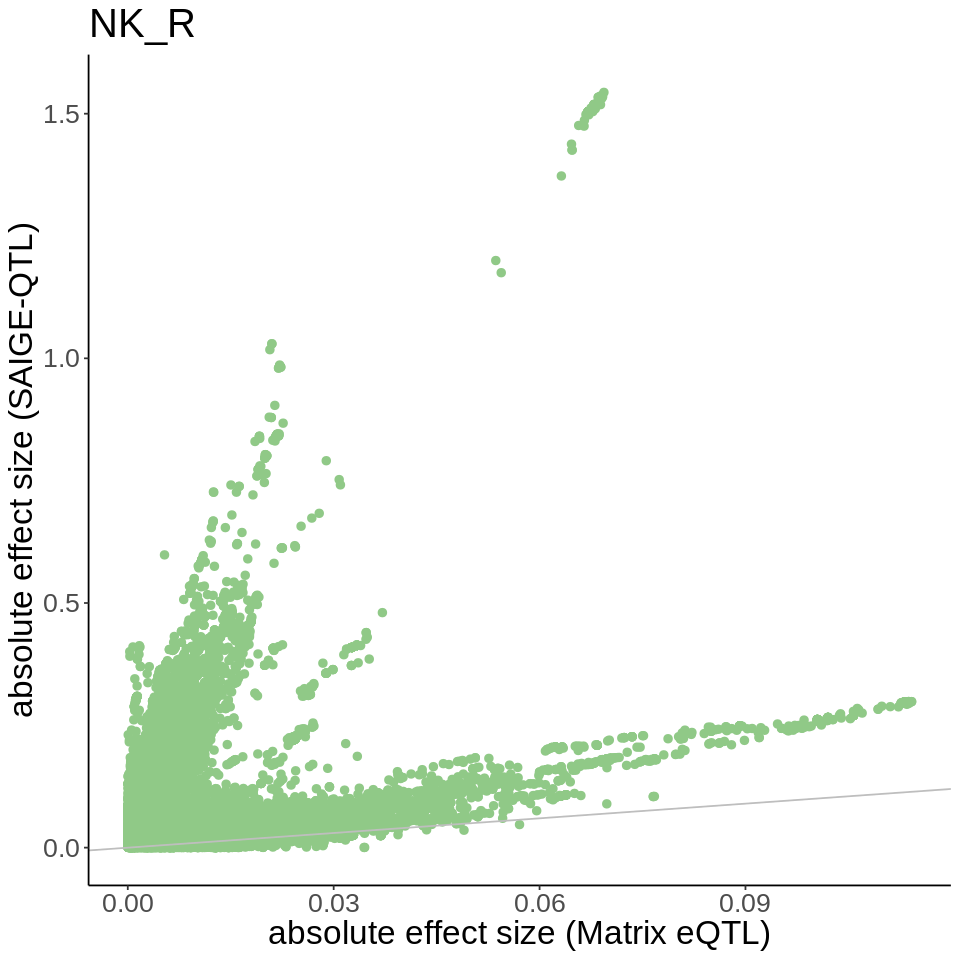

[1] "Plasma, cor abs betas: 0.41"


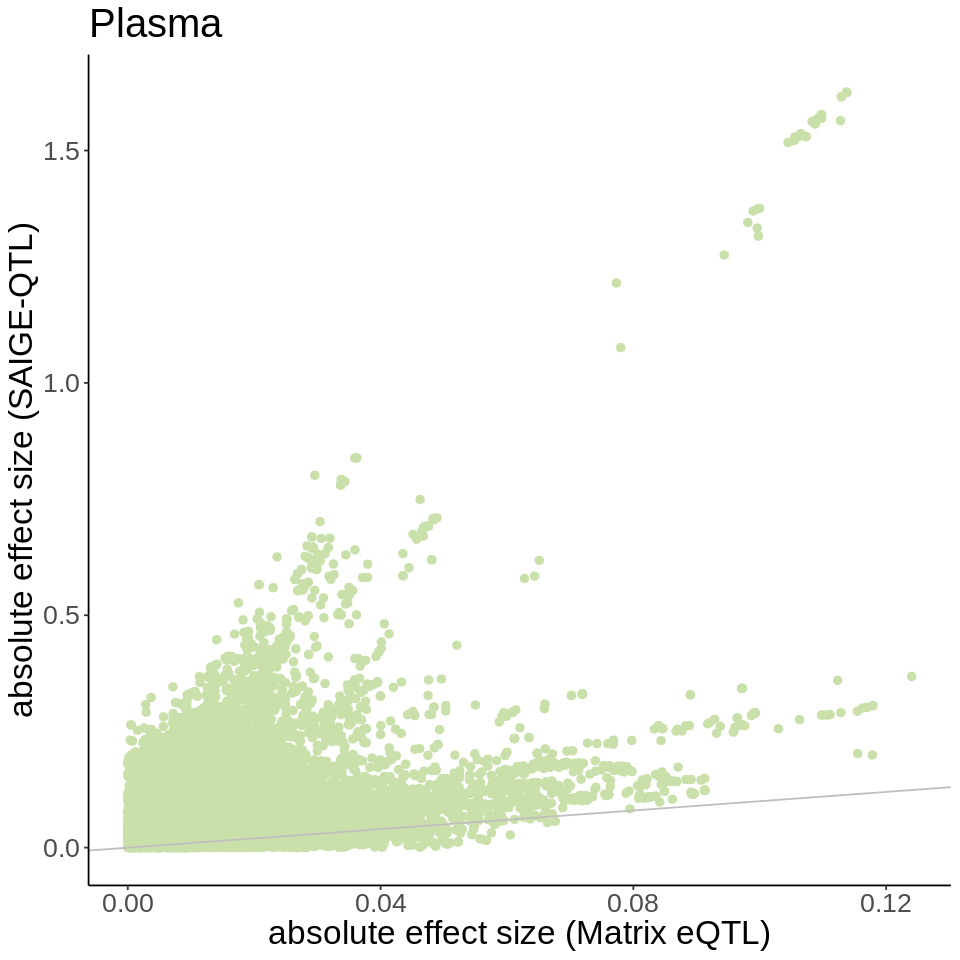

[1] "B_Mem, cor abs betas: 0.4"


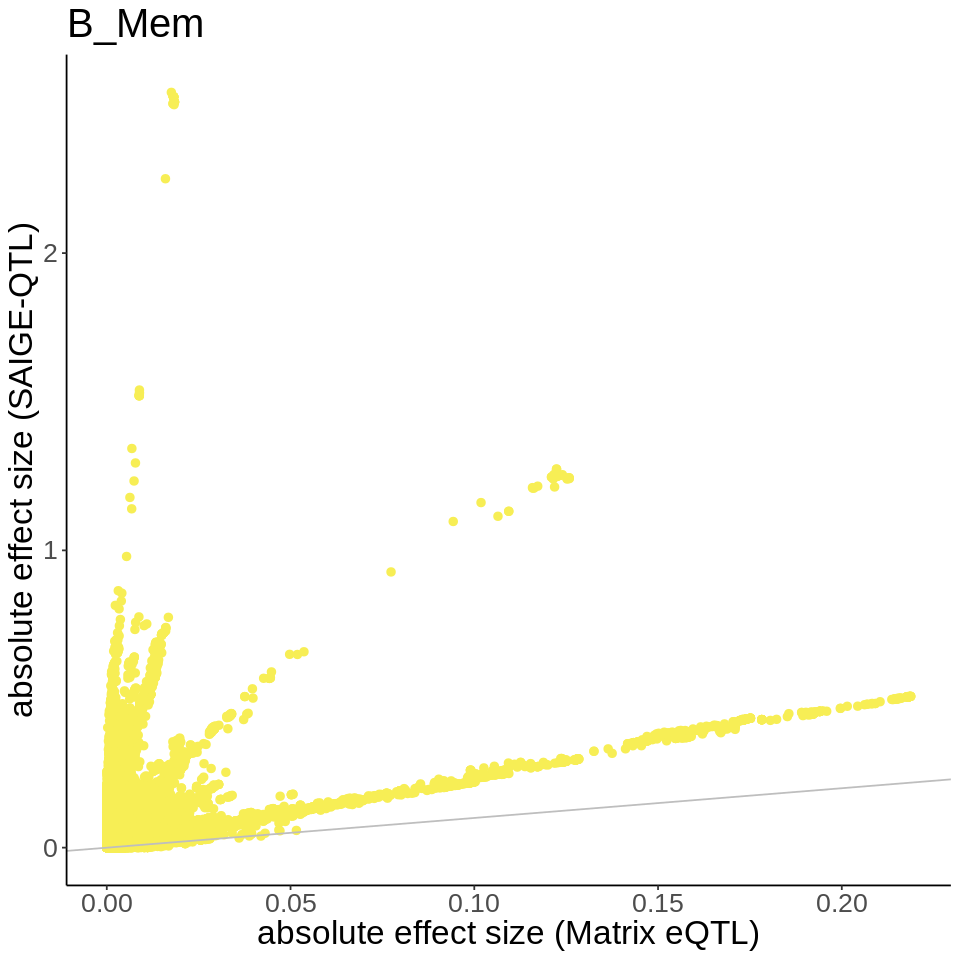

[1] "B_IN, cor abs betas: 0.33"


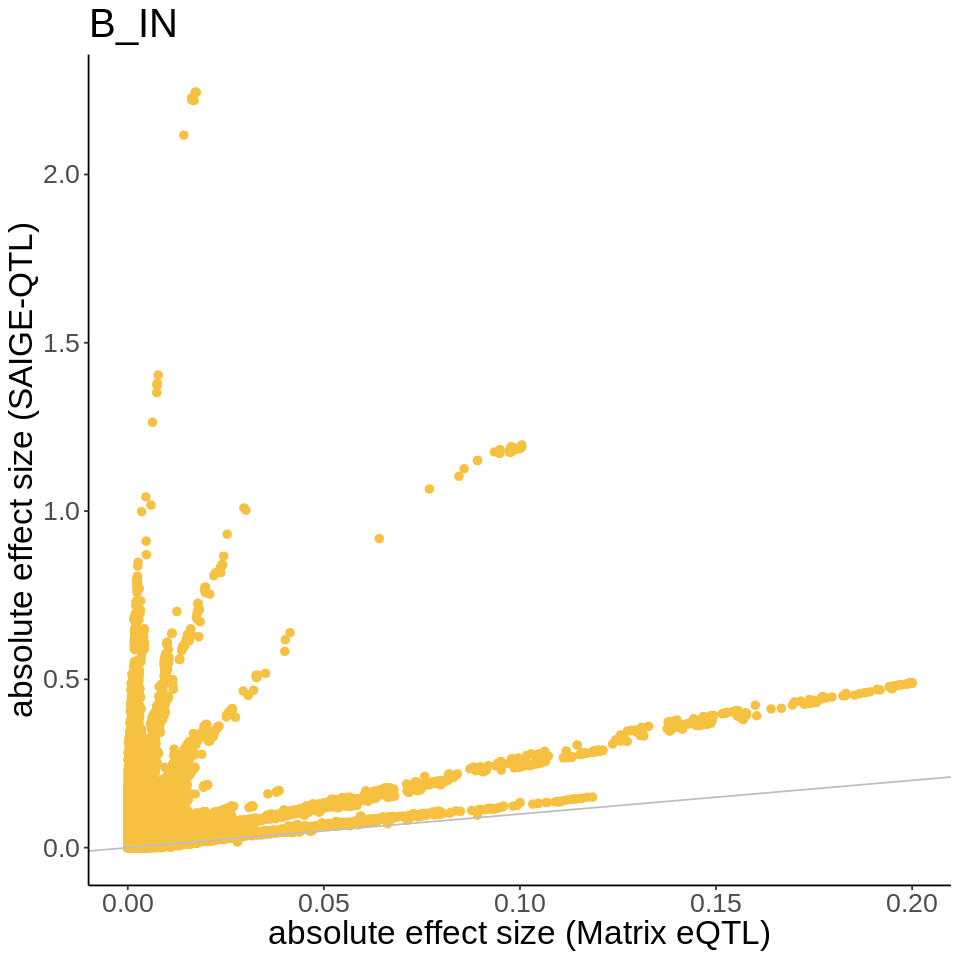

[1] "Mono_C, cor abs betas: 0.38"


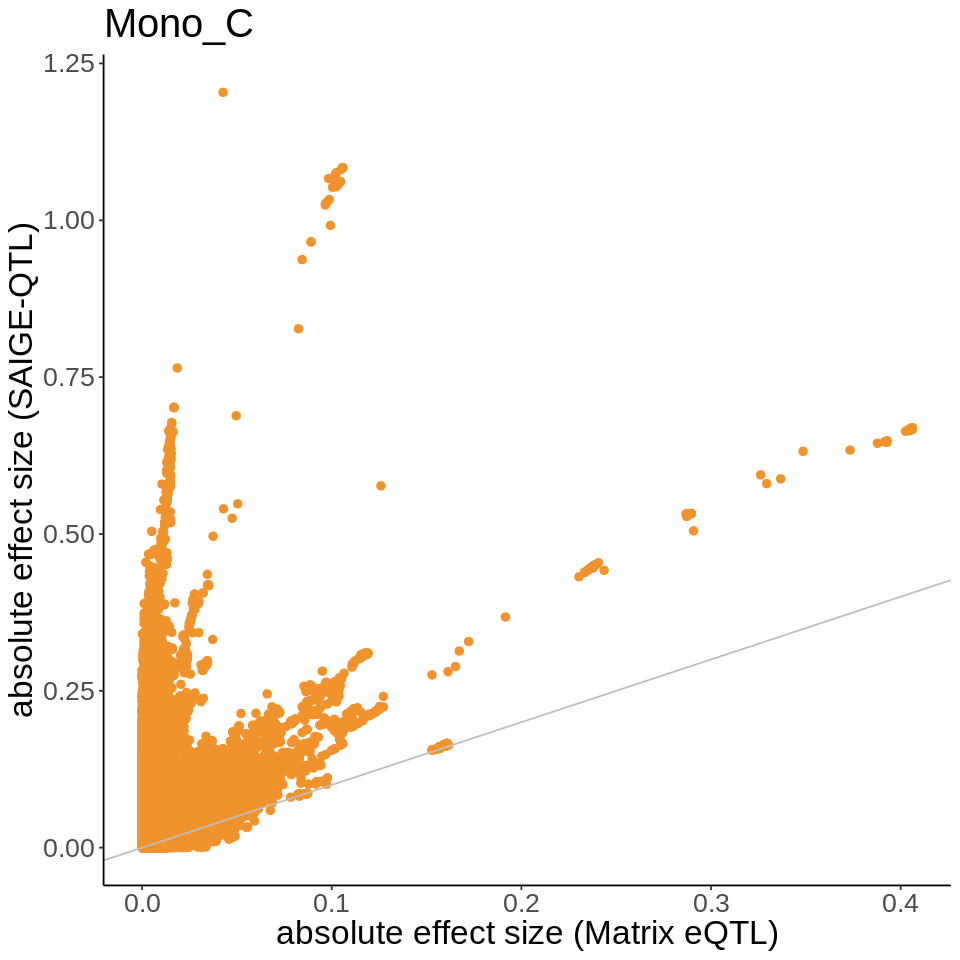

[1] "Mono_NC, cor abs betas: 0.48"


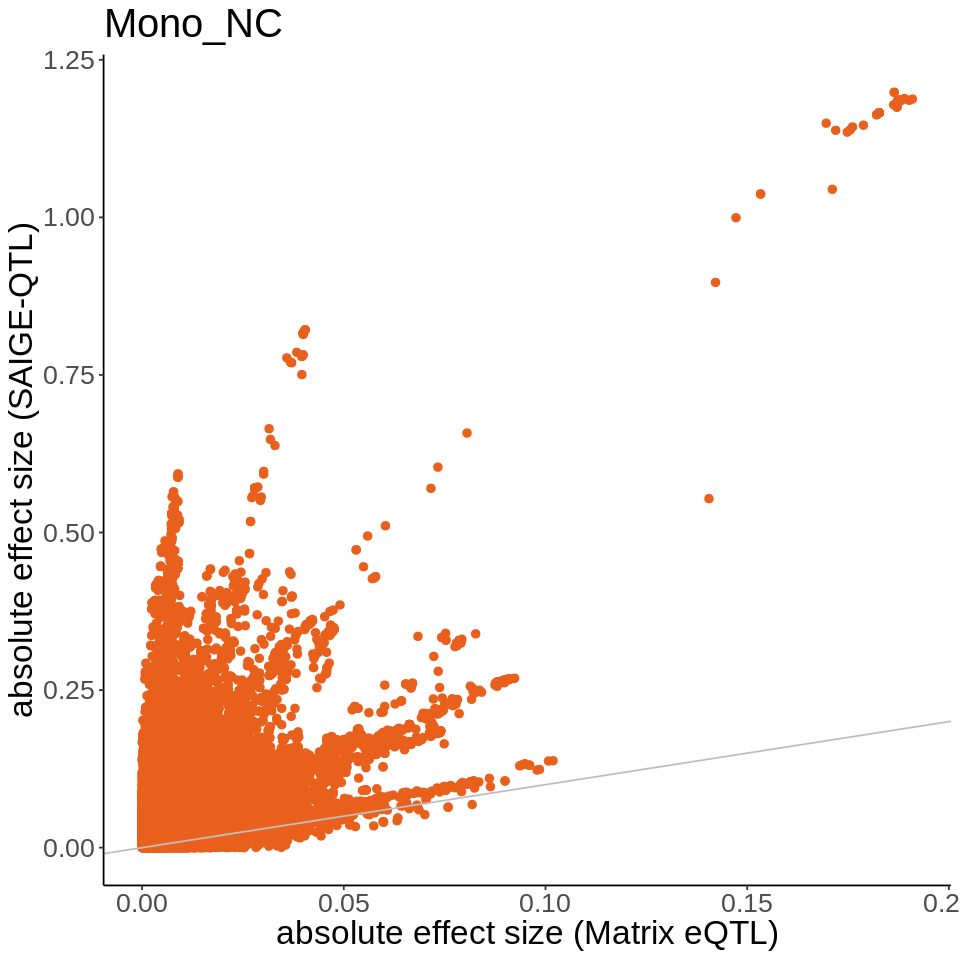

[1] "DC, cor abs betas: 0.52"


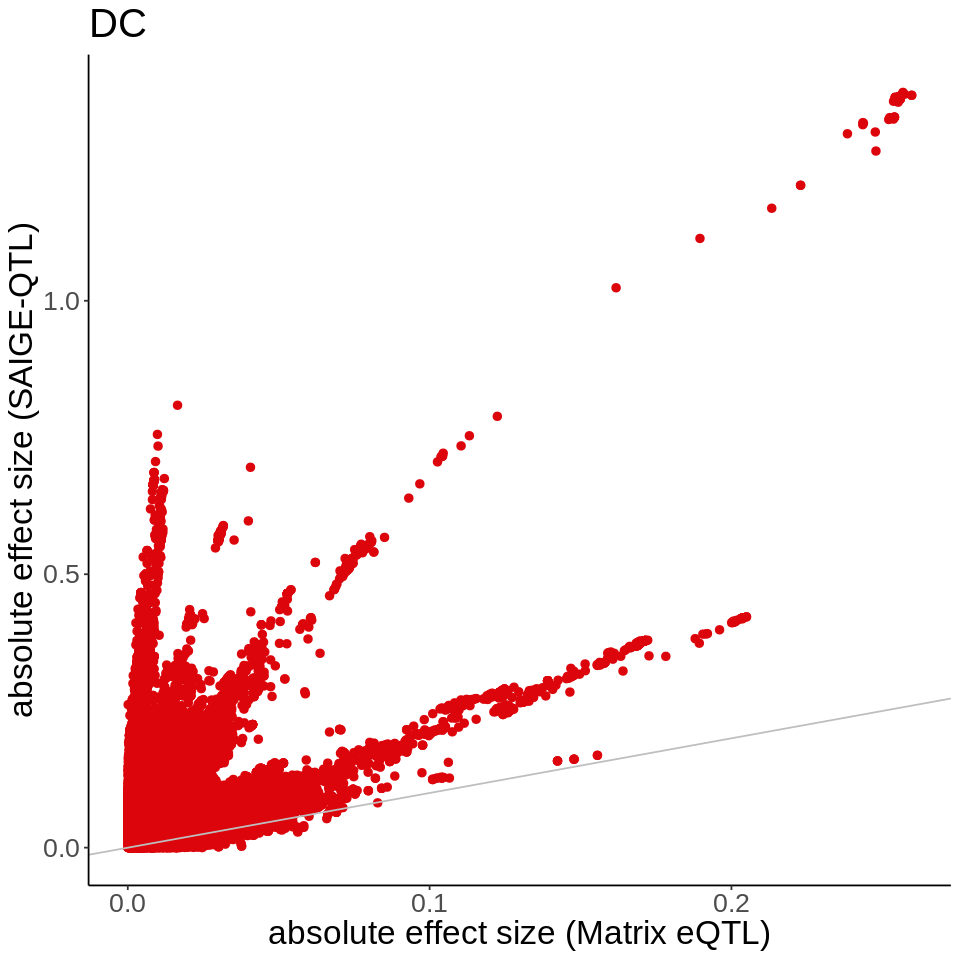

In [141]:
options(repr.plot.width = 8, repr.plot.height = 8)
cors_betas = c()
for (ct in celltypes){
    # load combined results
    df_both = fread(paste0(output_dir,"combined_",ct,".csv"))
    # establish plot colour based on cell type
    col = df_colours[df_colours$celltype == ct,"colours"]
    # plot betas
    M_saige = max(abs(df_both$beta_saige))
    M_matrix = max(abs(df_both$beta_matrix))
    p = ggplot(df_both, aes(x=abs(beta_matrix), y=abs(beta_saige))) + geom_point(col=col, size=2) 
    p = p + geom_abline(slope = 1, intercept = 0, col = "gray") + theme_classic() 
    p = p + theme(text = element_text(size=20)) + xlim(c(0,M_matrix)) + ylim(c(0,M_saige))
    p = p + xlab("absolute effect size (Matrix eQTL)") + ylab("absolute effect size (SAIGE-QTL)")
    p = p + ggtitle(ct)
    print(p)
    # save
    pdf(paste0(fig_dir,ct,"_abs_betas_scatter.pdf"), width=8, height=8)
    print(p)
    dev.off()
    # print correlations
    cor_betas = cor(abs(df_both$beta_matrix), abs(df_both$beta_saige))
    print(paste0(ct,", cor abs betas: ",round(cor_betas,digits=2)))
    cors_betas = c(cors_betas, cor_betas)
}

In [140]:
mean(cors_betas)

[1] 0.3969579